In [175]:
import pandas as pd
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [187]:
#input data
def input_data(folder):
    cv = pd.read_csv(folder+'/' + folder + '_video_result.csv')
    cv['pupil'] = pd.to_numeric(cv['pupil'], errors='coerce')
    cv['ratio'] = pd.to_numeric(cv['ratio'], errors='coerce')
    cv['x'] = pd.to_numeric(cv['x'], errors='coerce')
    cv['y'] = pd.to_numeric(cv['y'], errors='coerce')
    cv['ts'] = pd.to_numeric(cv['ts'], errors='coerce')
    cv['ts'] = np.around(cv['ts'], decimals=0)
    #seperate by steps
    cv = cv[cv['pupil'] > 0] #remove zeros
    
    s30_cv = cv[cv['step'] == 30]
    s31_cv = cv[cv['step'] == 31]
    s32_cv = cv[cv['step'] == 32]
    
    return cv, s30_cv, s31_cv, s32_cv

def input_eve_data(folder, step, step_num):
    left_pupil_db = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['left_p']['data']))
    right_pupil_db = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['right_p']['data']))
    px_2_mm = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['pixels_per_millimeter']))
    gaze_right = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['right_o']['data']))
    gaze_left = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['left_o']['data']))
    gaze_left = gaze_left.rename(columns={0: 'x', 1: 'y', 2: 'z'})
    gaze_right = gaze_right.rename(columns={0: 'x', 1: 'y', 2: 'z'})
    scale = pd.DataFrame(np.array(h5.File(folder+'/' + step + '_webcam_c.h5')['pixels_per_millimeter']))
    scale = scale[0][0]
    
    #normalise input data
    #eve db
    left_pupil_db *= scale
    right_pupil_db *= scale
    
    #insert the timestamp information for the eve data
    ts_eve = attach_ts(step_num, folder)
    left_pupil_db['ts'] = ts_eve
    
    # integrate into one dataframe with the coordinate
    left_pupil_db['x'] = gaze_left['x']
    left_pupil_db['y'] = gaze_left['y']

    right_pupil_db['ts'] = ts_eve
    right_pupil_db['x'] = gaze_right['x']
    right_pupil_db['y'] = gaze_right['y']

    left_pupil_db = left_pupil_db.rename(columns={0: 'pupil'})
    right_pupil_db = right_pupil_db.rename(columns={0: 'pupil'})
    left_pupil_db = left_pupil_db[left_pupil_db['pupil'] != 0]
    right_pupil_db = right_pupil_db[right_pupil_db['pupil'] != 0]
    
    return left_pupil_db, right_pupil_db, ts_eve

In [177]:
def attach_ts(stepnum, folder):
    f = open(folder+'/step_' + stepnum +'_webcam_c.timestamps.txt','r')
    ts = []
    for line in f.readlines():
        ts.append(float(line[:-1]))

    start = ts[0]
    for i in range(len(ts)):
        ts[i] -= start
        ts[i] /= 1000000 #from ms to s
        ts[i] = np.around(ts[i], decimals=0)
    return ts


In [178]:
from statsmodels.stats.stattools import medcouple
import math

def get_quartiles(arr):
    arr = [i for i in arr if not np.isnan(i)]
    arr = np.sort(arr)
    mid = int(len(arr)/2)
    if(len(arr)%2 == 0):
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    else:
        Q1 = np.median(arr[:mid])
        Q3 = np.median(arr[mid:])
    return Q1,Q3

def adjust_boxplot(values, param, bias=1.5, f=None):
    mc = np.around(medcouple(values), decimals=1)
    print('**medcouple', mc)
    
    if mc == 0: #tukeys method
        q1,q3 = get_quartiles(values)
        iqr = q3 - q1
        lowerLimit = np.around(q1 - bias*iqr, decimals=2)
        upperLimit = np.around(q3 + bias*iqr, decimals=2)
    else:
        q1,q3 = get_quartiles(values)
        iqr = q3 - q1
        if mc > 0:
            lowerLimit = np.around(q1 - bias*math.exp(-3.5*mc)*iqr, decimals=2)
            upperLimit = np.around(q3 + bias*math.exp(4*mc)*iqr, decimals=2)
        else:
            lowerLimit = np.around(q1 - bias*math.exp(-4*mc)*iqr, decimals=2)
            upperLimit = np.around(q3 + bias*math.exp(3.5*mc)*iqr, decimals=2)
        
    print('IQR', iqr, 'lower', lowerLimit, 'Q1', q1, 'Q3', q3, 'upper', upperLimit)
    result = []
    for v in values:
        if v < lowerLimit or v > upperLimit: 
            result.append(0)
        else:
            result.append(v)
            
    remove = np.around(1-(len([i for i in result if i != 0])/len(values)), decimals=2)
    print('remove ratio ', remove, '\n')
    if f is not None:
        f.write('\n remove outlier by param ' + param + ' with bias = ' + str(bias))
        f.write('\n** medcouple = ' + str(mc))
        f.write('\nIQR | LOWER | Q1 | UPPER | Q3: ')
        f.write(str(iqr) + ' | ' + str(lowerLimit) + ' | ' + str(q1) + ' | ' + str(q3) + ' | ' + str(upperLimit))
        f.write('\nremote ratio = ' + str(remove))
    return result

def remove_outliers(df, param, bias=1.5, f=None): 
    ad_value = adjust_boxplot(list(df[param]), param, bias, f)
    df[param] = ad_value
    df = df[df[param] != 0]
    
    return df


In [179]:
#merge function for cv db
def merge_both_side(ts, df_left, df_right):
    data = []
    print('ts len', len(ts))
    print( len([i for i in df_left['pupil'] if not np.isnan(i) and i != 0]))
    print( len([i for i in df_right['pupil'] if not np.isnan(i) and i != 0]))
    
    for t in ts:
        left_series = df_left[df_left['ts'] == t]
        right_series = df_right[df_right['ts'] == t]
        
        if len(left_series) != 0:
            left = list(left_series['pupil'])[0]
            y_left = list(left_series['y'])[0]
            x_left = list(left_series['x'])[0]
        else:
            left, y_left, x_left = np.nan, np.nan, np.nan
        
        if len(right_series) != 0:
            right = list(right_series['pupil'])[0]
            y_right = list(right_series['y'])[0]
            x_right = list(right_series['x'])[0]
        else:
            right, y_right, x_right = np.nan, np.nan, np.nan
        
        if not np.isnan(left) and not np.isnan(right):
            data.append([t, np.mean([left, right])])
        elif not np.isnan(right):
            data.append([t, right])
        elif not np.isnan(left):
            data.append([t, left])
        else:
            data.append([t, np.nan])
        
    print( len([i for i in data if not np.isnan(i[1])]))
    df = pd.DataFrame(data, columns=['ts', 'pupil'])
    df['pcps'] = df['pupil'].pct_change()
    df = df[df['pupil'] != np.nan]
    return df


In [180]:
### normalise into 1sec
def nor_1000(df, sec=1):
    video_length = np.around(list(df['ts'])[-1]/1000, decimals=0)
    print('video length', video_length)
    times = np.arange(0, video_length*1000, (1000*sec)) #interval
    start = 0
    data = []
    for t in times[1:]:
        rows = df[ (df['ts'] >= start) & (df['ts'] <= t)]
        values = sorted([i for i in rows['pupil'] if i != 0])
#         if len(values) >= 3:
#             data.append([start, np.around(np.nanmean(values[1:-1]), decimals=3)]) #ignore the maximum and minimum
#         else:
        data.append([start, np.around(np.nanmean(values), decimals=3)])
        start = t

    return pd.DataFrame(data, columns=['ts', 'pupil'])

In [188]:
def run(step_num, step_cv_df, folder):
    step_num = str(step_num)
    step = 'step_' + step_num
    save_file = folder+'/'+step
    suffix = 'video'
    f = open(save_file+'_log_'+suffix+ '.txt', 'w')
    f.write('\n\n step ' + step_num + '---------- ')
    ######################## input data ################################
    ts_cv = []
    for t in list(step_cv_df['ts']): #the whole ts list before removing any values
        if t not in ts_cv:
            ts_cv.append(t)
    
    #input eve data
    left_pupil_db, right_pupil_db, ts_eve = input_eve_data(folder, step, step_num)
    
    #### plot titles
    title_distrib = folder + '_' + step_num +'_Frequency_Histogram_(bin_30)-'+suffix
    title_scatter_e = folder + '_' + step_num +'_eve(x,y)_scatter-'+suffix
    title_scatter_c = folder + '_' + step_num +'_cv(x,y)_scatter-'+suffix
    title_scatter_p = folder + '_' + step_num +'_pupil_scatter-'+suffix

    
    ## distribution visualize
    plt.hist(list(left_pupil_db['pupil']) + list(right_pupil_db['pupil']), bins=30, label='eve')
    plt.hist(list(step_cv_df['pupil']), bins=30, label='cv')
    plt.gca().set(title=title_distrib , ylabel='Frequency')
    plt.legend(loc='best')
    plt.savefig(save_file+title_distrib+'.png', dpi=100, bbox_inches="tight")
    plt.grid()
    
    ######################## Clean data ################################
    #clean cv data
    before_size = len(list(step_cv_df['pupil']))
    step_cv_df = remove_outliers(step_cv_df, 'pupil', f=f)
    step_cv_df = remove_outliers(step_cv_df, 'y', 3, f=f)
    step_cv_df = remove_outliers(step_cv_df, 'x', 3, f=f)
#     step_cv_df = remove_outliers(step_cv_df, 'pupil', f=f)
        
    f.write('\nafter clean cv data, total remove ratio: ' + str(np.around(1-(len(list(step_cv_df['pupil']))/before_size), decimals=2)))
    print('** after clean cv data, remove ratio', 1-(len(list(step_cv_df['pupil']))/before_size), '\n')
#     print('two eyes distances sd', np.nanstd([i for i in step_cv_df['d2'] if i != -1]))
    
    changes_cv_left = step_cv_df[step_cv_df['side'] == 'L'] #select individual side
    changes_cv_right = step_cv_df[step_cv_df['side'] == 'R']
    
    #clean eve data
    left_pupil_db = remove_outliers(left_pupil_db, 'pupil', f=f)
    right_pupil_db = remove_outliers(right_pupil_db, 'pupil', f=f)
    
    
    ##################### ALL ########################
    #plot eve coordinate
    _, (ax1, ax2) = plt.subplots(2, figsize=(15, 6))
    ax1.scatter(x=list(left_pupil_db['ts']), y=list(left_pupil_db['x']), label='left x', s=5)
    ax1.scatter(x=list(right_pupil_db['ts']), y=list(right_pupil_db['x']), label='right x', s=5)
    ax2.scatter(x=list(left_pupil_db['ts']), y=list(left_pupil_db['y']), label='left y', s=5)
    ax2.scatter(x=list(right_pupil_db['ts']), y=list(right_pupil_db['y']), label='right y', s=5)
    ax2.grid()
    ax1.set_title(title_scatter_e)
    ax2.legend(loc='best')
    ax1.grid()
    ax1.legend(loc='best')
    plt.savefig(save_file+title_scatter_e+'.png', dpi=100, bbox_inches="tight")
    plt.show()
    
    #plot cv coordinate
    _, (ax1, ax2) = plt.subplots(2, figsize=(15, 6))
    ax1.scatter(x=changes_cv_left['ts'], y=list(changes_cv_left['x']), label='left x', s=5)
    ax1.scatter(x=changes_cv_right['ts'], y=list(changes_cv_right['x']), label='right x', s=5)
    ax2.scatter(x=changes_cv_left['ts'], y=list(changes_cv_left['y']*-1), label='left y', s=5)
    ax2.scatter(x=changes_cv_right['ts'], y=list(changes_cv_right['y']*-1), label='right y', s=5)
    ax2.grid()
    ax1.set_title(title_scatter_c)
    ax2.legend(loc='best')
    ax1.grid()
    ax1.legend(loc='best')
    plt.savefig(save_file+title_scatter_c+'.png', dpi=100, bbox_inches="tight")
    plt.show()

    #merge both side
    print('cv db')
    cv = merge_both_side(ts_cv, changes_cv_left, changes_cv_right)
    print('\neve db')
    eve = merge_both_side(ts_eve, left_pupil_db, right_pupil_db) 
    
    y_db = list(eve['pupil'])
    y_cv = list(cv['pupil'])
    video_length = np.around(list(eve['ts'])[-1]/1000, decimals=0)
    freq_eve = np.around(len(y_db)/video_length, decimals=0)
    freq_cv = np.around(len(y_cv)/video_length, decimals=0)
    
    f.write('\nEVE ' + str(freq_eve) + ' hz | CV ' + str(freq_cv) + ' hz')
    print('EVE ' + str(freq_eve) + ' hz | CV ' + str(freq_cv) + ' hz')
    
    title_1sec = folder + '_' + step_num +'_1_sec_(EVE_'+ str(freq_eve) + 'Hz|CV_' + str(freq_cv) + 'Hz)-'+suffix
    title_2sec = folder + '_' + step_num +'_2_sec_(EVE_'+ str(freq_eve) + 'Hz|CV_' + str(freq_cv) + 'Hz)-'+suffix
    
    plt.figure(figsize=(15, 6))
    plt.title(title_scatter_p)
    plt.scatter(x=eve['ts'], y=y_db, label='eve', s=5)
    plt.scatter(x=cv['ts'], y=y_cv, label='cv', s=5)
    plt.grid()
    plt.legend(loc='best')
    plt.savefig(fname=save_file+title_scatter_p+'.png', dpi=100, bbox_inches="tight")
    plt.show()
    
    ##################### 1 sec ########################
    #merge into 1 sec timeframe
    print('1 SEC Timeframe')
    f.write('\n--- 1 SEC timeframe ---')
    cv_new = nor_1000(cv)
    eve_new = nor_1000(eve)

    cv_new['pcps'] = cv_new['pupil'].pct_change()
    eve_new['pcps'] = eve_new['pupil'].pct_change()

    cv_new.head(5)
    eve_new.head(5)
    #plot
    y_cv = list(cv_new['pupil']-5)
    y_db = list(eve_new['pupil'])

    _, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 6), sharex=True)
    ax1.set_title(title_1sec)
    ax1.plot(list(cv_new['pcps']*2), label='cv pcps')
    ax1.plot(list(eve_new['pcps']*2), label='eve pcps')
    ax2.plot(y_cv, label='cv pupil')
    ax2.plot(y_db, label='eve pupil')
    ax3.plot(abs(np.array(y_db) - np.array(y_cv)), label='pupil pixels difference')
    # plt.ylim(bottom=-2, top=2)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    ax3.legend(loc='best')
    plt.savefig(fname=save_file+'_1sec-'+suffix+'.png', dpi=100, bbox_inches="tight")
    plt.show()
    
    ### write to log
    print(len(y_db), len(y_cv))
    f.write('length of results: ')
    f.write(str(len(y_db)))
    f.write(' eve <- | -> opencv ')
    f.write(str(len(y_cv)))
    
    print('in terms of pupil radius')
    diff = abs(np.array(y_db) - np.array(y_cv))
    diff = np.around(diff, decimals=3)
    print('diff between two mean| max| min:', np.nanmean(diff), np.nanmax(diff), np.nanmin(diff))
    f.write('\ndiffence between eve and cv pupils')
    f.write(str(diff))
    f.write('\n mean | max | min ')
    f.write(str(np.nanmean(diff)) + ' | ' + str(np.nanmax(diff)) + ' | ' + str(np.nanmin(diff)))
    print('\ndiff sd', np.nanstd(diff))
    f.write('\ndiff sd')
    f.write(str(np.nanstd(diff)))
    
    print('eve mean| max| min:', np.nanmean(y_db), np.nanmax(y_db), np.nanmin(y_db))
    f.write('\neve results\n')
    f.write('mean | max | min ')
    f.write(str(np.nanmean(y_db)) + ' | ' + str(np.nanmax(y_db)) + ' | ' + str(np.nanmin(y_db)))
    print('cv mean| max| min:', np.nanmean(y_cv), np.nanmax(y_cv), np.nanmin(y_cv))
    f.write('\nopencv results\n')
    f.write('mean | max | min ')
    f.write(str(np.nanmean(y_cv)) + ' | ' + str(np.nanmax(y_cv)) + ' | ' + str(np.nanmin(y_cv)))
    print('\ncv sd', np.nanstd(y_cv))
    print('\neve sd', np.nanstd(y_db))
    f.write('\nstandard deviation ')
    f.write(str(np.nanstd(y_db)))
    f.write(' eve <- | -> opencv ')
    f.write(str(np.nanstd(y_cv)))
    
    ##################### 2 sec ########################
    print('2 SEC Timeframe')
    f.write('\n--- 2 SEC timeframe ---')
    cv_new = nor_1000(cv, 2)
    eve_new = nor_1000(eve, 2)

    cv_new['pcps'] = cv_new['pupil'].pct_change()
    eve_new['pcps'] = eve_new['pupil'].pct_change()

    cv_new.head(5)
    eve_new.head(5)
    #plot
    y_cv = list(cv_new['pupil']-5)
    y_db = list(eve_new['pupil'])

    _, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 6), sharex=True)
    ax1.set_title(title_2sec)
    ax1.plot(list(cv_new['pcps']*2), label='cv pcps')
    ax1.plot(list(eve_new['pcps']*2), label='eve pcps')
    ax2.plot(y_cv, label='cv pupil')
    ax2.plot(y_db, label='eve pupil')
    ax3.plot(abs(np.array(y_db) - np.array(y_cv)), label='pupil pixels difference')
    # plt.ylim(bottom=-2, top=2)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    ax3.legend(loc='best')
    plt.savefig(fname=save_file+'_2sec_'+suffix+'.png', dpi=100, bbox_inches="tight")
    plt.show()
    
    #### write to log
    print(len(y_db), len(y_cv))
    f.write('length of results: ')
    f.write(str(len(y_db)))
    f.write(' eve <- | -> opencv ')
    f.write(str(len(y_cv)))
    
    print('in terms of pupil radius')
    diff = abs(np.array(y_db) - np.array(y_cv))
    diff = np.around(diff, decimals=3)
    print('diff between two mean| max| min:', np.nanmean(diff), np.nanmax(diff), np.nanmin(diff))
    f.write('\ndiffence between eve and cv pupils')
    f.write(str(diff))
    f.write('\n mean | max | min ')
    f.write(str(np.nanmean(diff)) + ' | ' + str(np.nanmax(diff)) + ' | ' + str(np.nanmin(diff)))
    print('\ndiff sd', np.nanstd(diff))
    f.write('\ndiff sd')
    f.write(str(np.nanstd(diff)))
    
    print('eve mean| max| min:', np.nanmean(y_db), np.nanmax(y_db), np.nanmin(y_db))
    f.write('\neve results\n')
    f.write('mean | max | min ')
    f.write(str(np.nanmean(y_db)) + ' | ' + str(np.nanmax(y_db)) + ' | ' + str(np.nanmin(y_db)))
    print('cv mean| max| min:', np.nanmean(y_cv), np.nanmax(y_cv), np.nanmin(y_cv))
    f.write('\nopencv results\n')
    f.write('mean | max | min ')
    f.write(str(np.nanmean(y_cv)) + ' | ' + str(np.nanmax(y_cv)) + ' | ' + str(np.nanmin(y_cv)))
    print('\ncv sd', np.nanstd(y_cv))
    print('\neve sd', np.nanstd(y_db))
    f.write('\nstandard deviation ')
    f.write(str(np.nanstd(y_db)))
    f.write(' eve <- | -> opencv ')
    f.write(str(np.nanstd(y_cv)))
    
    f.close()

In [189]:
cv_36, s30_cv36, s31_cv36, s32_cv36 = input_data('train36')

**medcouple 0.4
IQR 4.0 lower 12.52 Q1 14.0 Q3 18.0 upper 47.72
remove ratio  0.04 

**medcouple 0.3
IQR 22.0 lower -8.1 Q1 15.0 Q3 37.0 upper 256.13
remove ratio  0.0 

**medcouple 0.1
IQR 38.5 lower 52.61 Q1 134.0 Q3 172.5 upper 344.81
remove ratio  0.0 

** after clean cv data, remove ratio 0.04347826086956519 

**medcouple 0.0
IQR 1.3762266635894775 lower 5.86 Q1 7.921529054641724 Q3 9.297755718231201 upper 11.36
remove ratio  0.0 

**medcouple -0.1
IQR 1.4170565605163574 lower 5.06 Q1 8.234967231750488 Q3 9.652023792266846 upper 11.15
remove ratio  0.0 



C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


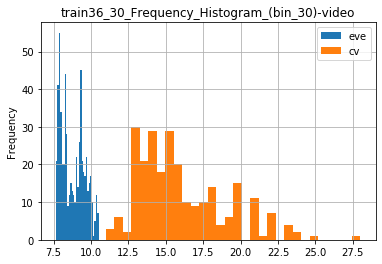

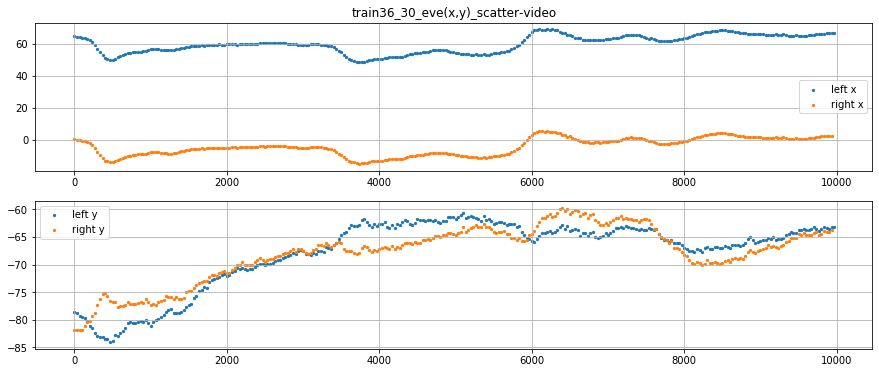

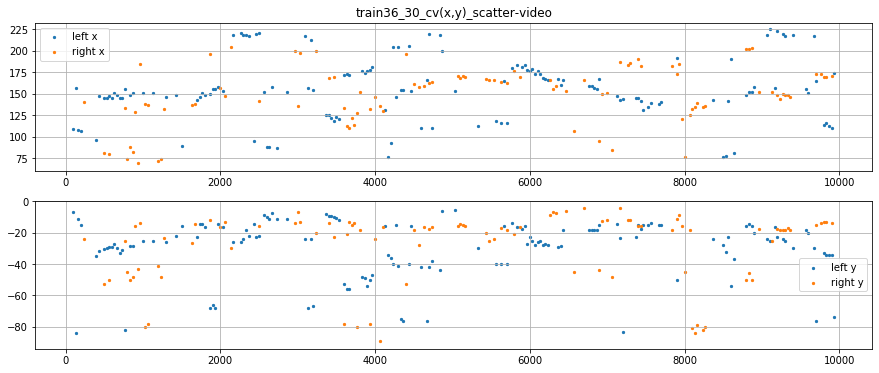

cv db
ts len 216
144
98
210

eve db
ts len 300
300
299
300
EVE 30.0 hz | CV 22.0 hz


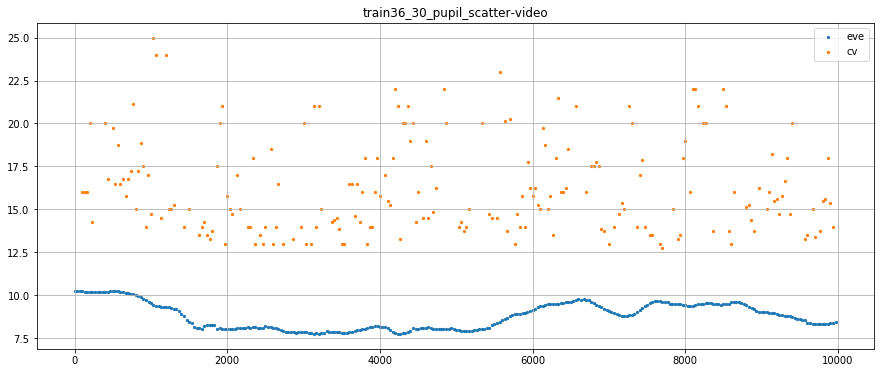

1 SEC Timeframe
video length 10.0
video length 10.0


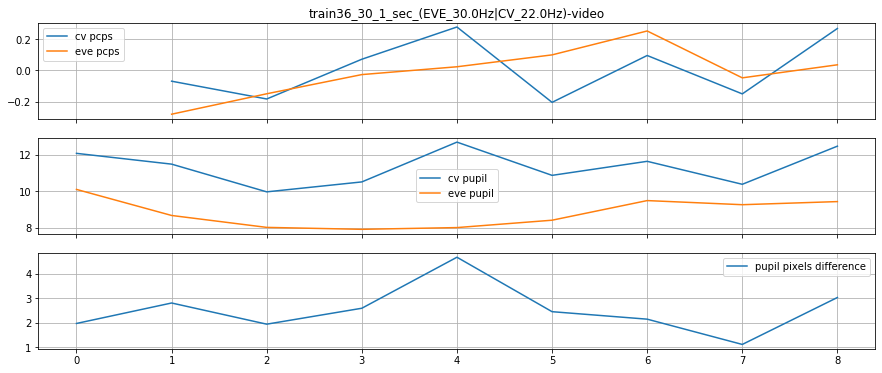

9 9
in terms of pupil radius
diff between two mean| max| min: 2.5235555555555553 4.669 1.115

diff sd 0.9261028393951732
eve mean| max| min: 8.811222222222224 10.095 7.915
cv mean| max| min: 11.334777777777777 12.678999999999998 9.962

cv sd 0.9083369147058172

eve sd 0.7404154656194014
2 SEC Timeframe
video length 10.0
video length 10.0


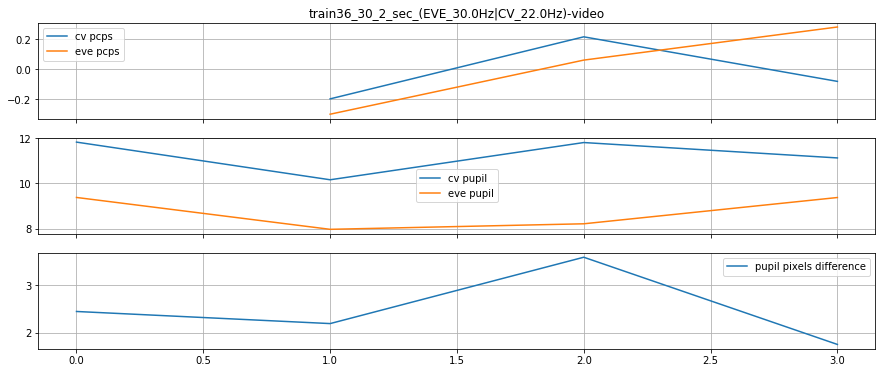

4 4
in terms of pupil radius
diff between two mean| max| min: 2.4985 3.597 1.753

diff sd 0.681458912921388
eve mean| max| min: 8.736 9.381 7.97
cv mean| max| min: 11.2345 11.831 10.164

cv sd 0.679338096973812

eve sd 0.6493046280444952
**medcouple 0.3
IQR 4.0 lower 12.9 Q1 15.0 Q3 19.0 upper 38.92
remove ratio  0.04 

**medcouple 0.3
IQR 15.5 lower 6.23 Q1 22.5 Q3 38.0 upper 192.39
remove ratio  0.0 

**medcouple 0.3
IQR 28.0 lower 112.61 Q1 142.0 Q3 170.0 upper 448.89
remove ratio  0.08 

** after clean cv data, remove ratio 0.11158342189160464 

**medcouple 0.0
IQR 1.0733389854431152 lower 6.08 Q1 7.6868720054626465 Q3 8.760210990905762 upper 10.37
remove ratio  0.0 

**medcouple 0.1
IQR 1.2188243865966797 lower 6.48 Q1 7.768975734710693 Q3 8.987800121307373 upper 11.72
remove ratio  0.0 



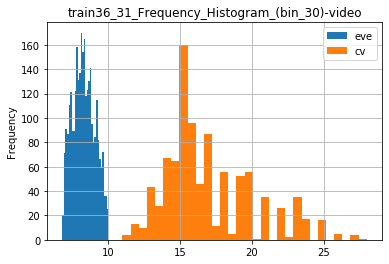

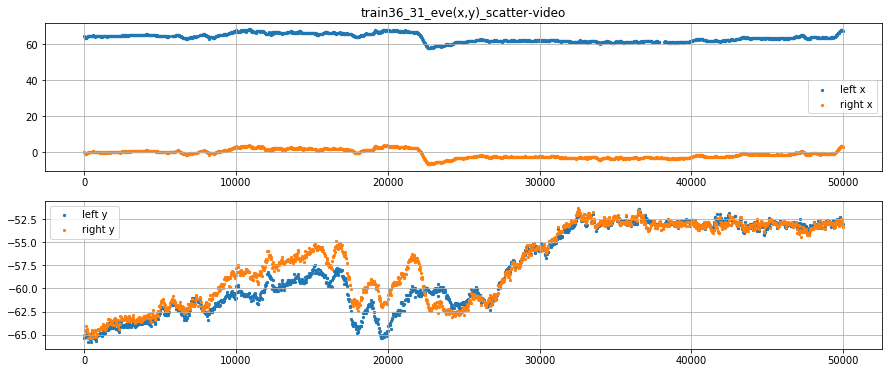

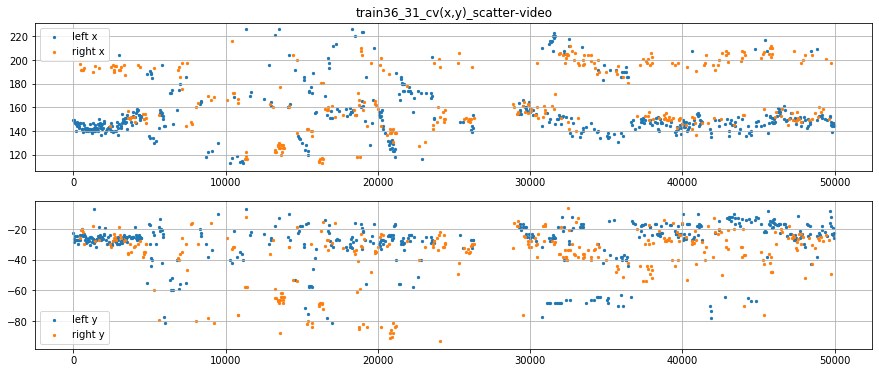

cv db
ts len 835
506
330
763

eve db
ts len 1500
1482
1496
1497
EVE 30.0 hz | CV 17.0 hz


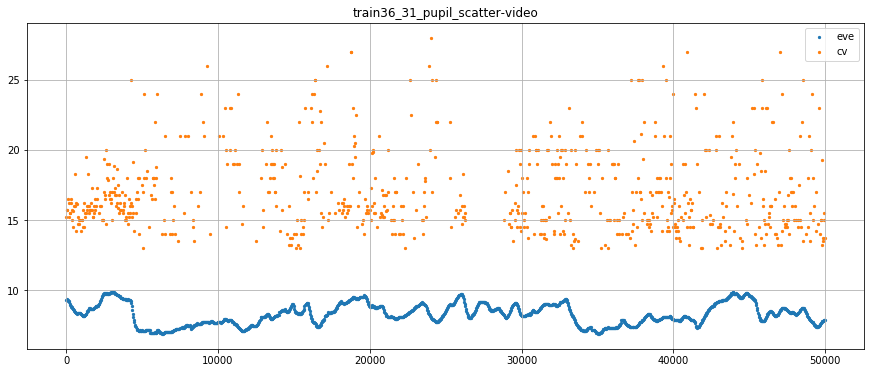

1 SEC Timeframe
video length 50.0
video length 50.0


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


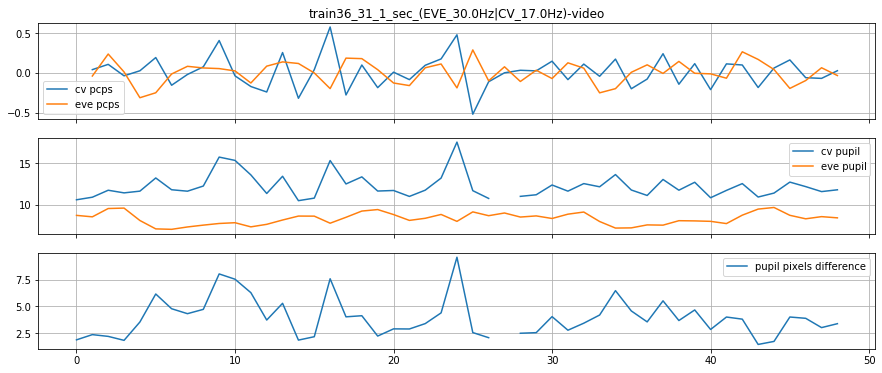

49 49
in terms of pupil radius
diff between two mean| max| min: 3.9355208333333334 9.587 1.46

diff sd 1.768713656747743
eve mean| max| min: 8.307877551020407 9.655 7.012
cv mean| max| min: 12.229229166666668 17.562 10.479

cv sd 1.42209770584958

eve sd 0.6981220182412141
2 SEC Timeframe
video length 50.0
video length 50.0


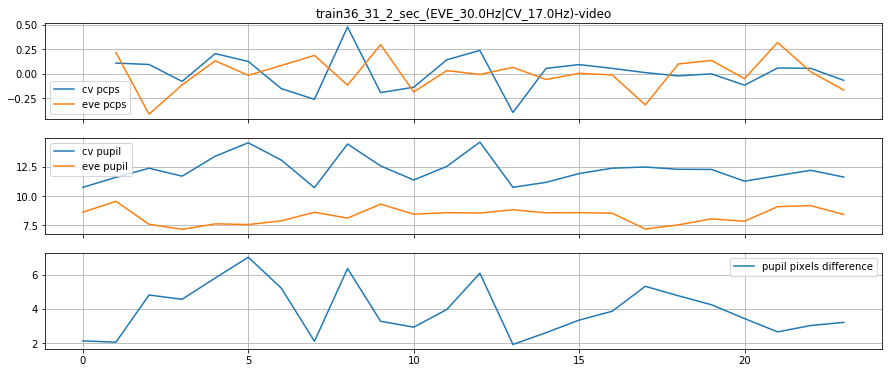

24 24
in terms of pupil radius
diff between two mean| max| min: 3.9445 7.011 1.925

diff sd 1.4395092624455972
eve mean| max| min: 8.305791666666666 9.549 7.149
cv mean| max| min: 12.250291666666664 14.625 10.719

cv sd 1.1071894026154192

eve sd 0.6468550184782952
**medcouple 0.2
IQR 6.5 lower 10.66 Q1 15.5 Q3 22.0 upper 43.7
remove ratio  0.0 

**medcouple 0.1
IQR 8.5 lower 7.03 Q1 25.0 Q3 33.5 upper 71.54
remove ratio  0.04 

**medcouple 0.3
IQR 43.5 lower 100.83 Q1 146.5 Q3 190.0 upper 623.28
remove ratio  0.08 

** after clean cv data, remove ratio 0.11306532663316582 

**medcouple -0.1
IQR 0.7906489372253418 lower 6.14 Q1 7.913557529449463 Q3 8.704206466674805 upper 9.54
remove ratio  0.03 

**medcouple 0.0
IQR 0.8878169059753418 lower 6.68 Q1 8.011292934417725 Q3 8.899109840393066 upper 10.23
remove ratio  0.0 



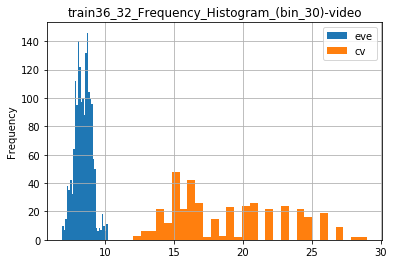

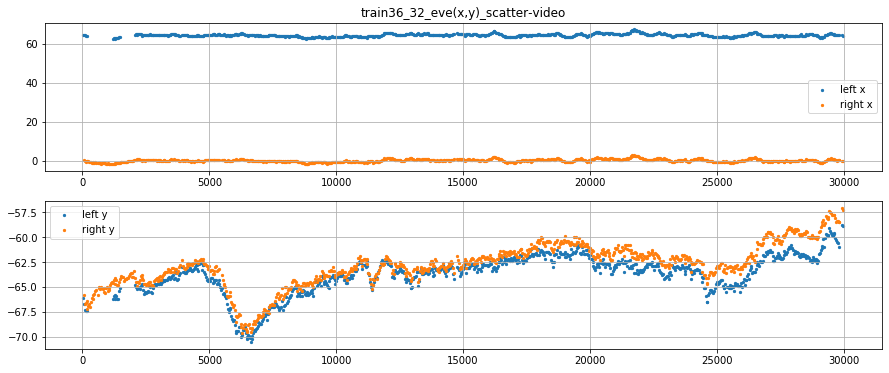

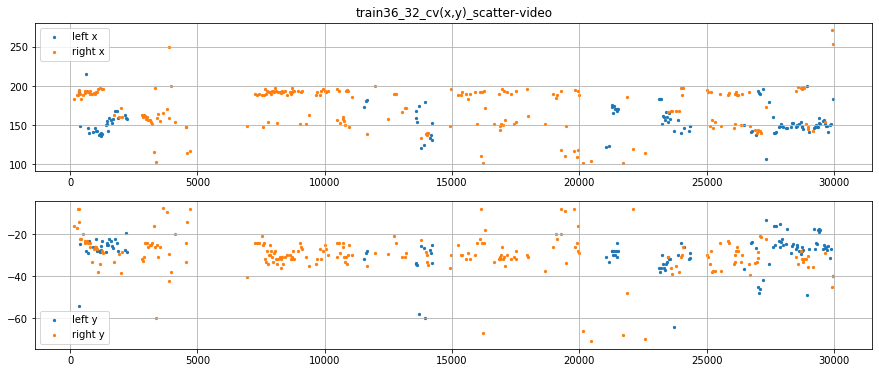

cv db
ts len 366
124
229
335

eve db
ts len 900
843
885
890
EVE 30.0 hz | CV 12.0 hz


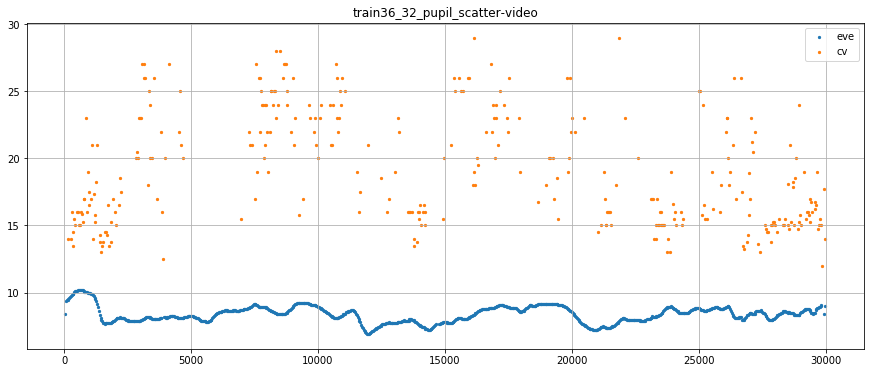

1 SEC Timeframe
video length 30.0
video length 30.0


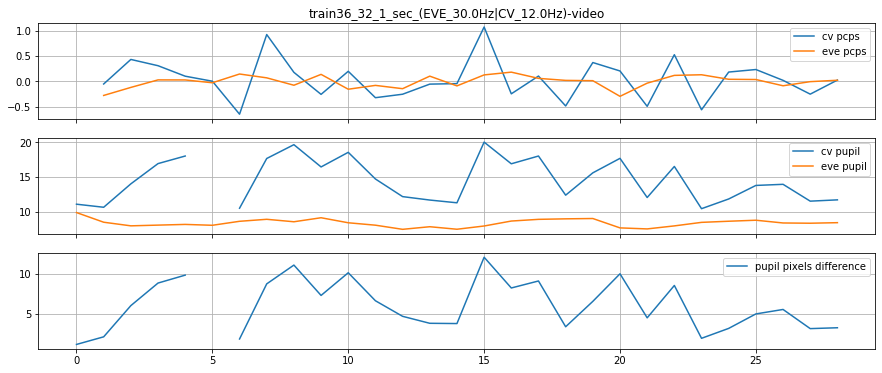

29 29
in terms of pupil radius
diff between two mean| max| min: 6.097964285714285 12.057 1.202

diff sd 3.074299275353455
eve mean| max| min: 8.369586206896551 9.875 7.465
cv mean| max| min: 14.479107142857144 20.0 10.431

cv sd 3.025589037565197

eve sd 0.543770141425862
2 SEC Timeframe
video length 30.0
video length 30.0


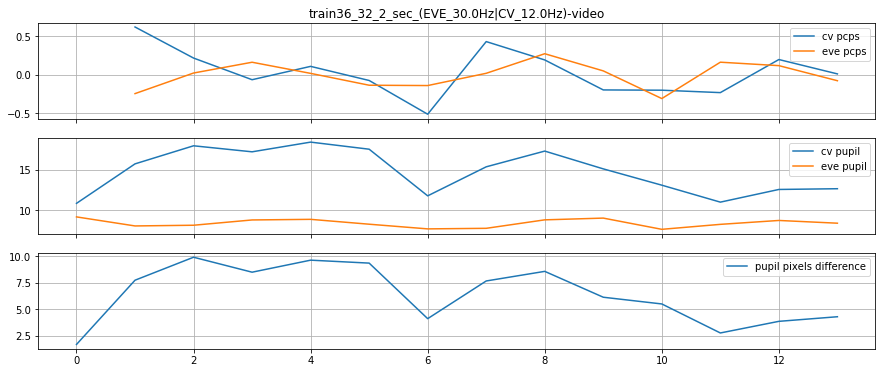

14 14
in terms of pupil radius
diff between two mean| max| min: 6.403214285714285 9.894 1.687

diff sd 2.618831969152099
eve mean| max| min: 8.366142857142856 9.144 7.597
cv mean| max| min: 14.769357142857144 18.458 10.831

cv sd 2.634475757205999

eve sd 0.49350841028335873


In [190]:
run('30', s30_cv36, 'train36')
run('31', s31_cv36, 'train36')
run('32', s32_cv36, 'train36')

**medcouple 0.0
IQR 1.5 lower 13.5 Q1 15.75 Q3 17.25 upper 19.5
remove ratio  0.09 

**medcouple 0.1
IQR 7.5 lower 18.14 Q1 34.0 Q3 41.5 upper 75.07
remove ratio  0.04 

**medcouple -0.1
IQR 10.0 lower 99.25 Q1 144.0 Q3 154.0 upper 175.14
remove ratio  0.02 

** after clean cv data, remove ratio 0.14423076923076927 

**medcouple 0.1
IQR 0.6652164459228516 lower 8.82 Q1 9.52585744857788 Q3 10.191073894500732 upper 11.68
remove ratio  0.06 

**medcouple -0.1


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


IQR 0.5979905128479004 lower 8.34 Q1 9.68242883682251 Q3 10.28041934967041 upper 10.91
remove ratio  0.04 



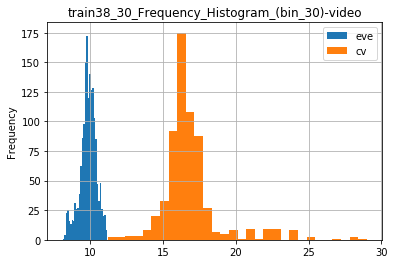

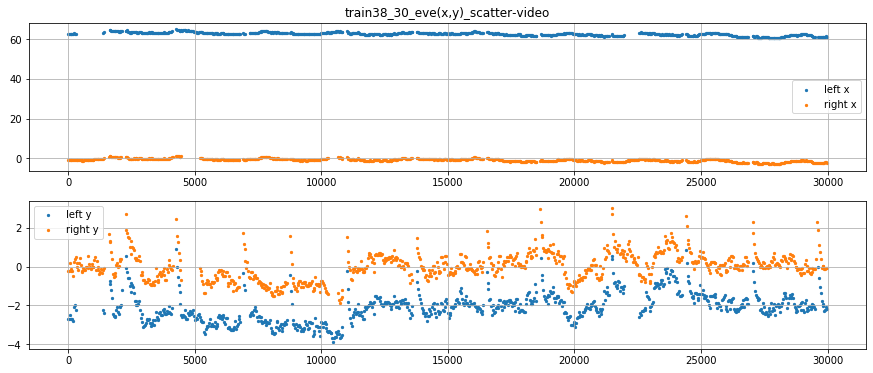

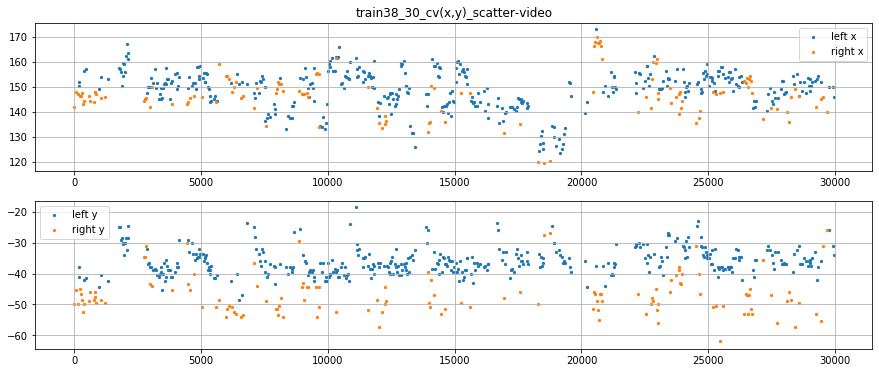

cv db
ts len 607
403
131
534

eve db
ts len 900
801
824
859
EVE 30.0 hz | CV 20.0 hz


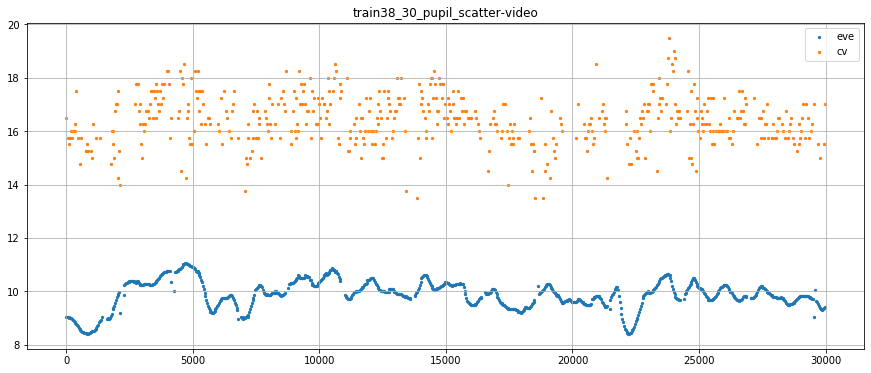

1 SEC Timeframe
video length 30.0
video length 30.0


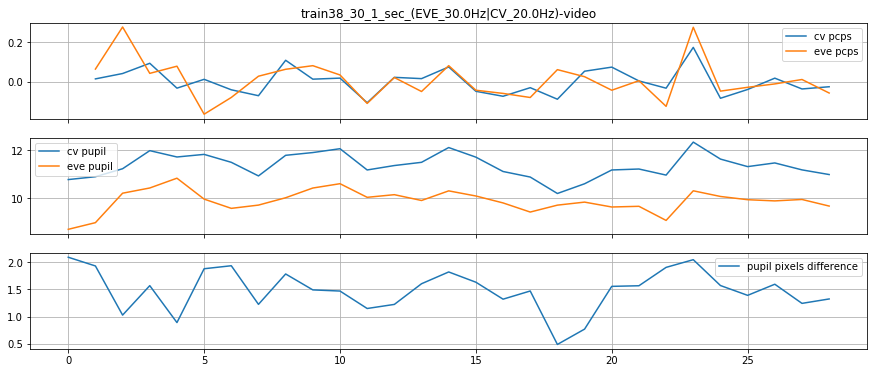

29 29
in terms of pupil radius
diff between two mean| max| min: 1.4799655172413793 2.088 0.489

diff sd 0.37635561711641463
eve mean| max| min: 9.886724137931033 10.834 8.688
cv mean| max| min: 11.366689655172415 12.347999999999999 10.192

cv sd 0.4899387085838866

eve sd 0.46064257192809765
2 SEC Timeframe
video length 30.0
video length 30.0


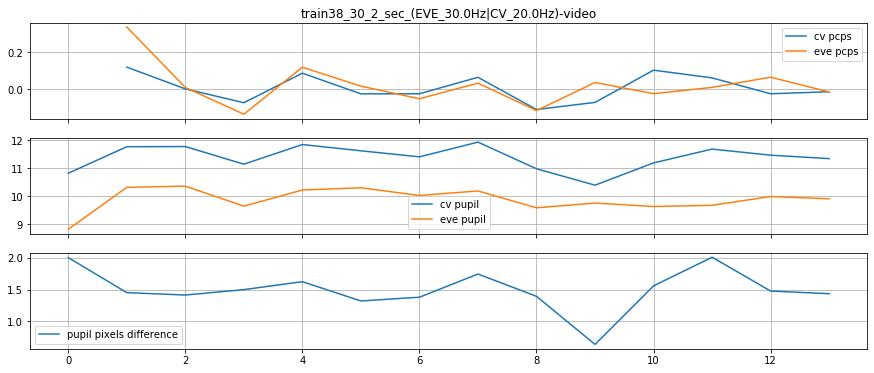

14 14
in terms of pupil radius
diff between two mean| max| min: 1.4951428571428573 2.007 0.637

diff sd 0.3166015650946915
eve mean| max| min: 9.891214285714286 10.364 8.822
cv mean| max| min: 11.386357142857142 11.934999999999999 10.398

cv sd 0.42441684481564257

eve sd 0.39911333488325457
**medcouple 0.1
IQR 2.25 lower 13.37 Q1 15.75 Q3 18.0 upper 23.03
remove ratio  0.03 

**medcouple 0.0
IQR 10.0 lower 0.0 Q1 30.0 Q3 40.0 upper 70.0
remove ratio  0.0 

**medcouple -0.1
IQR 13.0 lower 92.32 Q1 150.5 Q3 163.5 upper 190.98
remove ratio  0.03 

** after clean cv data, remove ratio 0.06165703275529866 

**medcouple 0.1
IQR 0.5031042098999023 lower 8.74 Q1 9.275247573852539 Q3 9.778351783752441 upper 10.9
remove ratio  0.02 

**medcouple 0.1
IQR 0.48797035217285156 lower 8.73 Q1 9.24886703491211 Q3 9.736837387084961 upper 10.83
remove ratio  0.02 



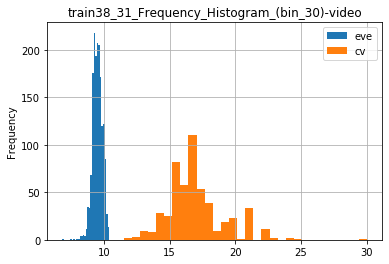

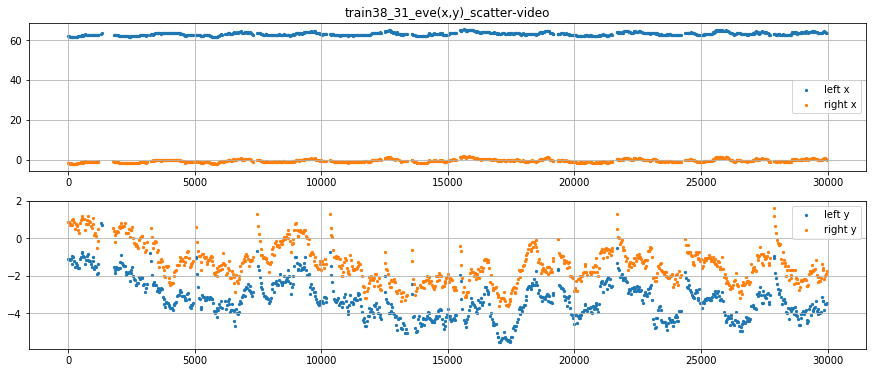

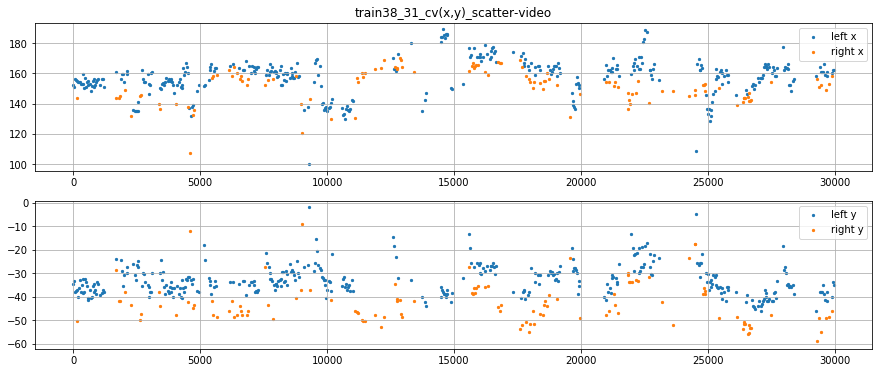

cv db
ts len 507
368
119
487

eve db
ts len 900
841
835
849
EVE 30.0 hz | CV 17.0 hz


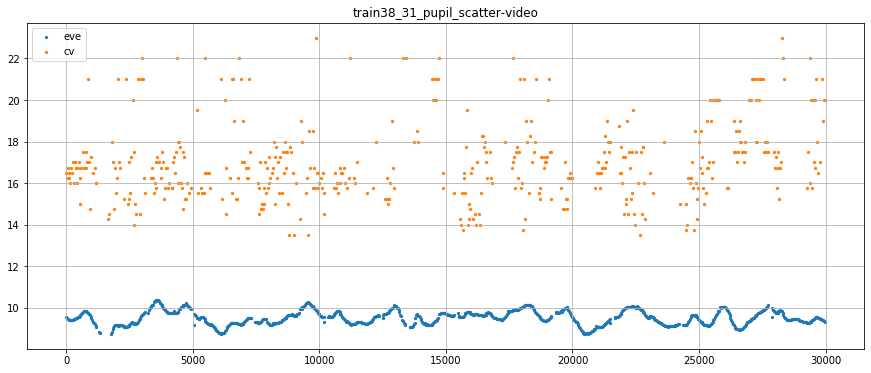

1 SEC Timeframe
video length 30.0
video length 30.0


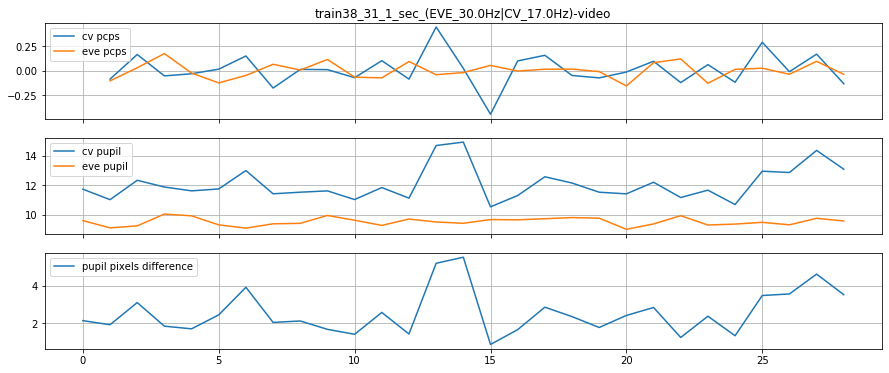

29 29
in terms of pupil radius
diff between two mean| max| min: 2.544655172413793 5.516 0.864

diff sd 1.15059889280688
eve mean| max| min: 9.52648275862069 10.043 9.006
cv mean| max| min: 12.071137931034482 14.931999999999999 10.533

cv sd 1.1005742615166685

eve sd 0.26947479194877993
2 SEC Timeframe
video length 30.0
video length 30.0


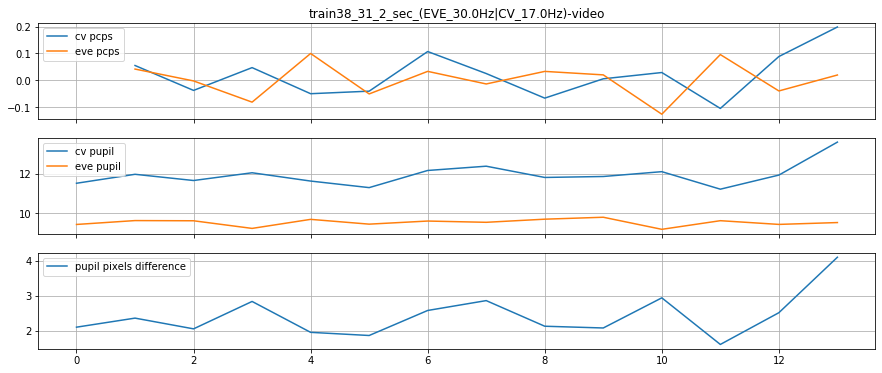

14 14
in terms of pupil radius
diff between two mean| max| min: 2.4269285714285718 4.102 1.607

diff sd 0.6055170711626452
eve mean| max| min: 9.524857142857142 9.791 9.175
cv mean| max| min: 11.951785714285718 13.622 11.222000000000001

cv sd 0.5618284154146589

eve sd 0.16807815237597792
**medcouple 0.3
IQR 1.5 lower 14.71 Q1 15.5 Q3 17.0 upper 24.47
remove ratio  0.06 

**medcouple 0.0
IQR 11.0 lower -1.0 Q1 32.0 Q3 43.0 upper 76.0
remove ratio  0.01 

**medcouple 0.4
IQR 22.25 lower 140.04 Q1 156.5 Q3 178.75 upper 509.36
remove ratio  0.05 

** after clean cv data, remove ratio 0.11111111111111116 

**medcouple -0.3
IQR 0.28198719024658203 lower 7.58 Q1 8.988457679748535 Q3 9.270444869995117 upper 9.42
remove ratio  0.09 

**medcouple -0.2
IQR 0.25334978103637695 lower 8.18 Q1 9.025778770446777 Q3 9.279128551483154 upper 9.47
remove ratio  0.05 



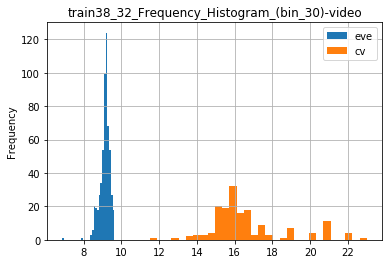

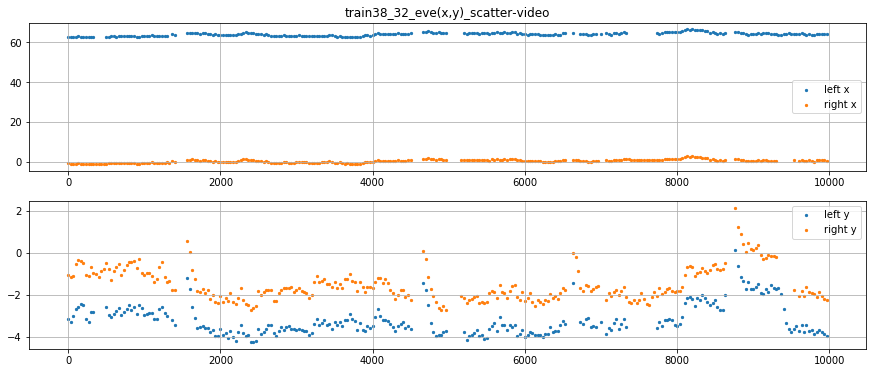

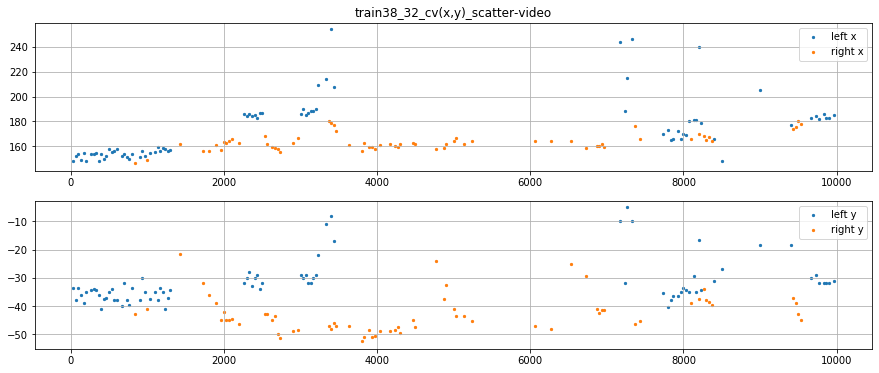

cv db
ts len 155
80
64
141

eve db
ts len 300
261
273
281
EVE 30.0 hz | CV 16.0 hz


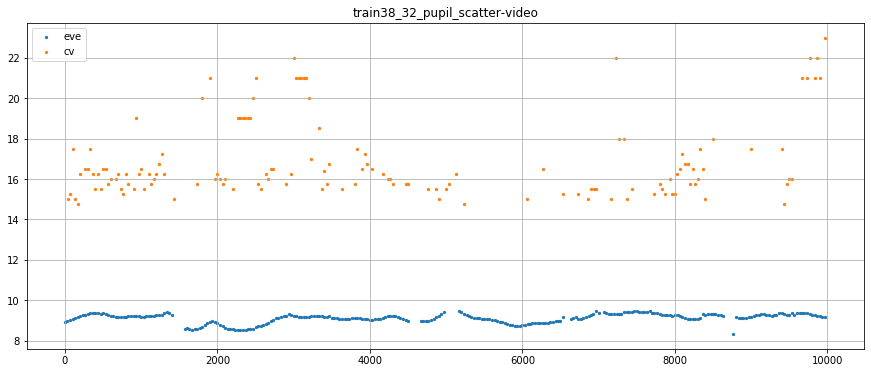

1 SEC Timeframe
video length 10.0
video length 10.0


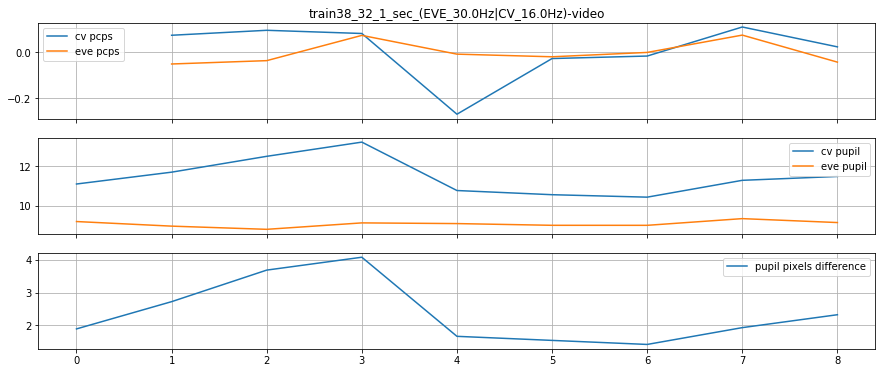

9 9
in terms of pupil radius
diff between two mean| max| min: 2.3645555555555555 4.078 1.422

diff sd 0.8983428089928343
eve mean| max| min: 9.08688888888889 9.354 8.814
cv mean| max| min: 11.451444444444444 13.216999999999999 10.438

cv sd 0.8632447974050658

eve sd 0.14547122238851867
2 SEC Timeframe
video length 10.0
video length 10.0


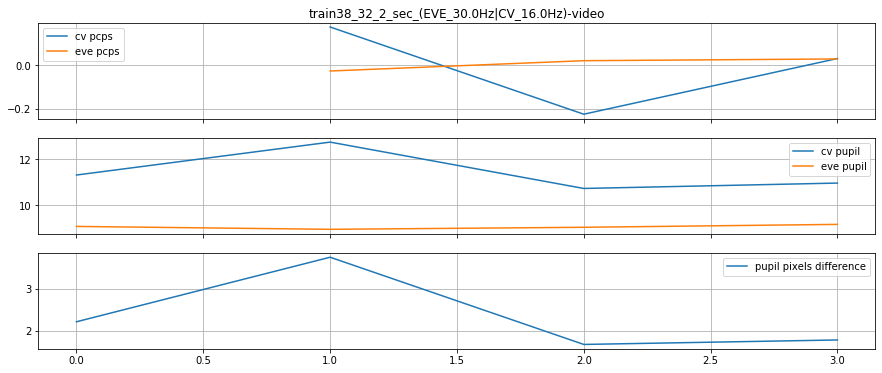

4 4
in terms of pupil radius
diff between two mean| max| min: 2.35525 3.756 1.672

diff sd 0.8338085436717472
eve mean| max| min: 9.0785 9.185 8.972
cv mean| max| min: 11.43375 12.728000000000002 10.732

cv sd 0.7751239820183614

eve sd 0.07643461257833419


In [191]:
cv_38, s30_cv38, s31_cv38, s32_cv38 = input_data('train38')
run('30', s30_cv38, 'train38')
run('31', s31_cv38, 'train38')
run('32', s32_cv38, 'train38')

**medcouple 0.0
IQR 3.0 lower 11.5 Q1 16.0 Q3 19.0 upper 23.5
remove ratio  0.03 

**medcouple -0.2
IQR 9.5 lower -27.43 Q1 36.0 Q3 45.5 upper 59.65
remove ratio  0.03 

**medcouple 0.0
IQR 14.25 lower 111.25 Q1 154.0 Q3 168.25 upper 211.0
remove ratio  0.03 

** after clean cv data, remove ratio 0.07972665148063784 

**medcouple 0.2
IQR 0.5752367973327637 lower 9.56 Q1 9.98996114730835 Q3 10.565197944641113 upper 12.49
remove ratio  0.04 



C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**medcouple 0.1
IQR 0.5460224151611328 lower 9.19 Q1 9.76257848739624 Q3 10.308600902557373 upper 11.53
remove ratio  0.02 



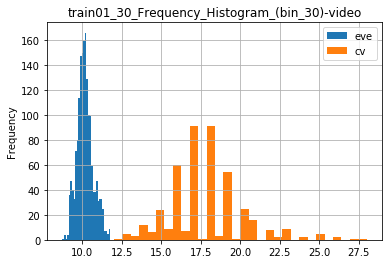

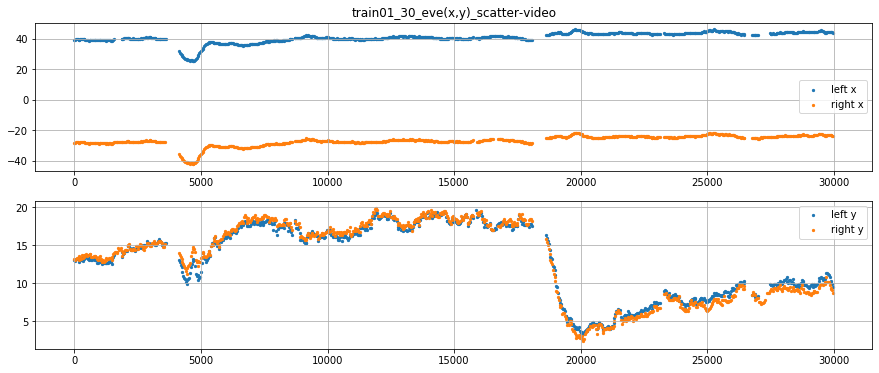

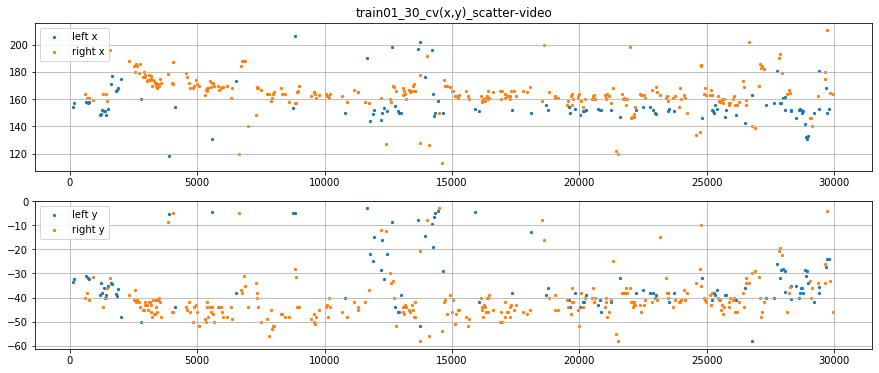

cv db
ts len 429
112
292
401

eve db
ts len 900
830
837
848
EVE 30.0 hz | CV 14.0 hz


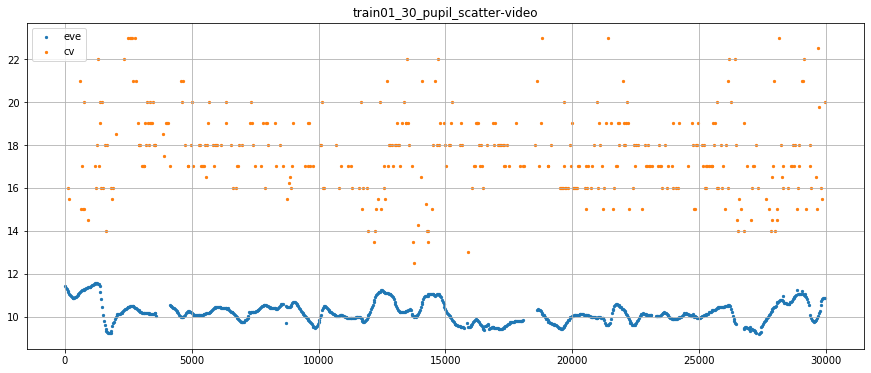

1 SEC Timeframe
video length 30.0
video length 30.0


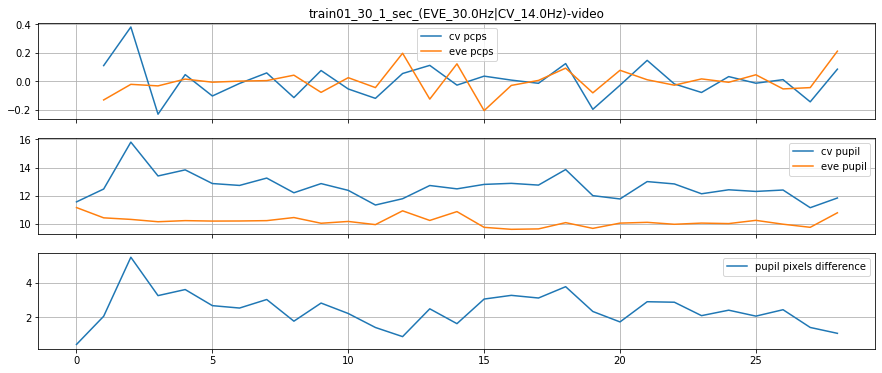

29 29
in terms of pupil radius
diff between two mean| max| min: 2.436724137931034 5.498 0.404

diff sd 0.992006913788189
eve mean| max| min: 10.17593103448276 11.152 9.604
cv mean| max| min: 12.612655172413792 15.808 11.143

cv sd 0.8851206532157682

eve sd 0.37110997821860386
2 SEC Timeframe
video length 30.0
video length 30.0


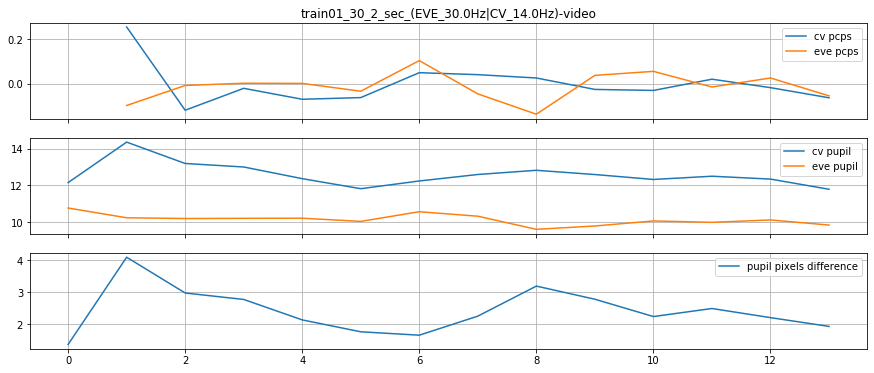

14 14
in terms of pupil radius
diff between two mean| max| min: 2.4265714285714286 4.1 1.377

diff sd 0.6813334315134985
eve mean| max| min: 10.1515 10.777 9.622
cv mean| max| min: 12.57807142857143 14.347999999999999 11.793

cv sd 0.6205913613281302

eve sd 0.287383206090504
**medcouple 0.0
IQR 4.0 lower 10.0 Q1 16.0 Q3 20.0 upper 26.0
remove ratio  0.02 

**medcouple -0.2
IQR 34.0 lower -209.01 Q1 18.0 Q3 52.0 upper 102.65
remove ratio  0.0 

**medcouple -0.0
IQR 36.0 lower 44.0 Q1 152.0 Q3 188.0 upper 296.0
remove ratio  0.0 

** after clean cv data, remove ratio 0.016831683168316847 

**medcouple 0.1
IQR 1.0029034614562988 lower 8.93 Q1 9.990153789520264 Q3 10.993057250976562 upper 13.24
remove ratio  0.01 

**medcouple 0.1
IQR 0.9431371688842773 lower 8.69 Q1 9.6843900680542 Q3 10.627527236938477 upper 12.74
remove ratio  0.01 



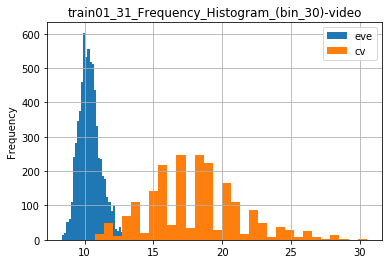

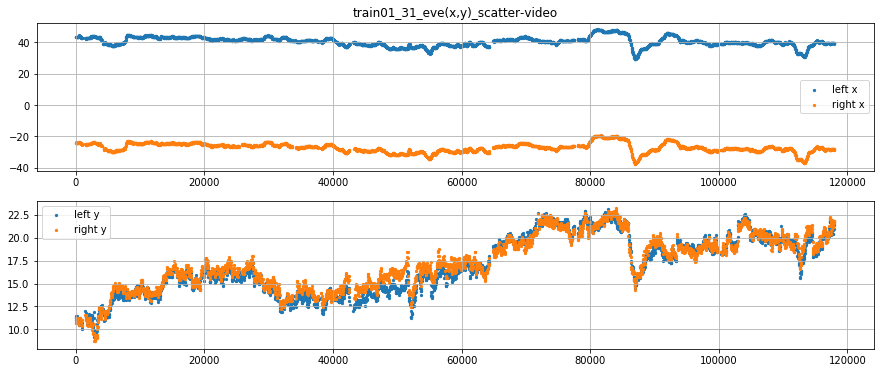

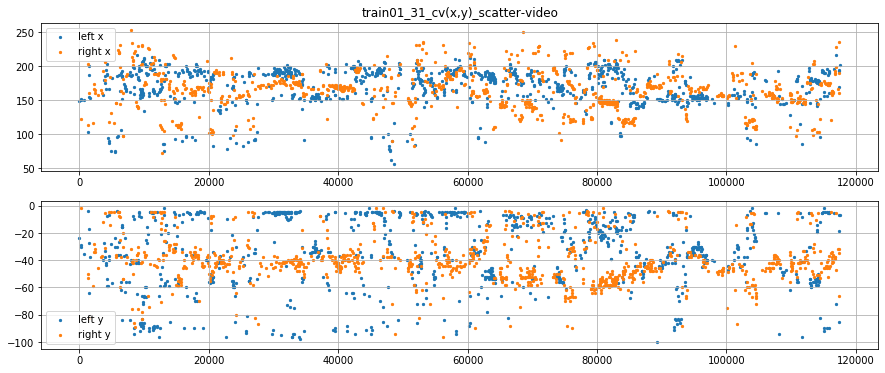

cv db
ts len 1814
991
995
1789

eve db
ts len 3540
3418
3349
3420
EVE 30.0 hz | CV 15.0 hz


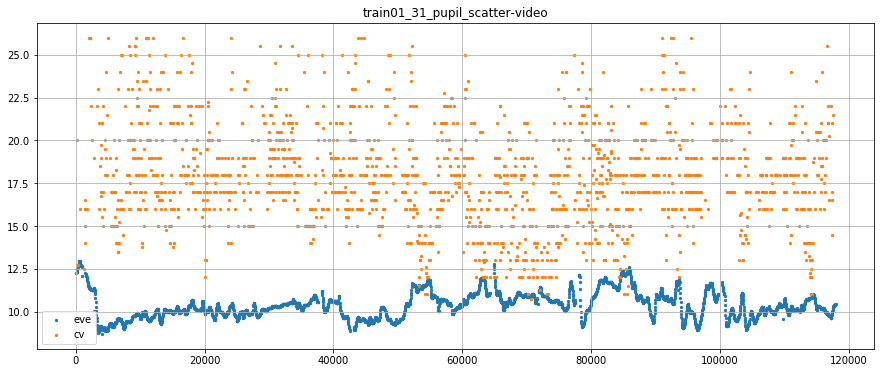

1 SEC Timeframe
video length 118.0
video length 118.0


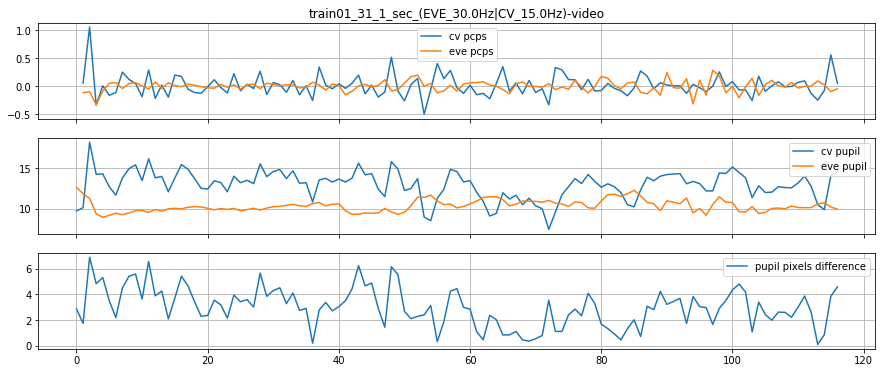

117 117
in terms of pupil radius
diff between two mean| max| min: 2.984299145299145 6.891 0.099

diff sd 1.495829634392725
eve mean| max| min: 10.388247863247864 12.617 8.968
cv mean| max| min: 12.932598290598289 18.167 7.5

cv sd 1.7242439892184784

eve sd 0.7176744364149168
2 SEC Timeframe
video length 118.0
video length 118.0


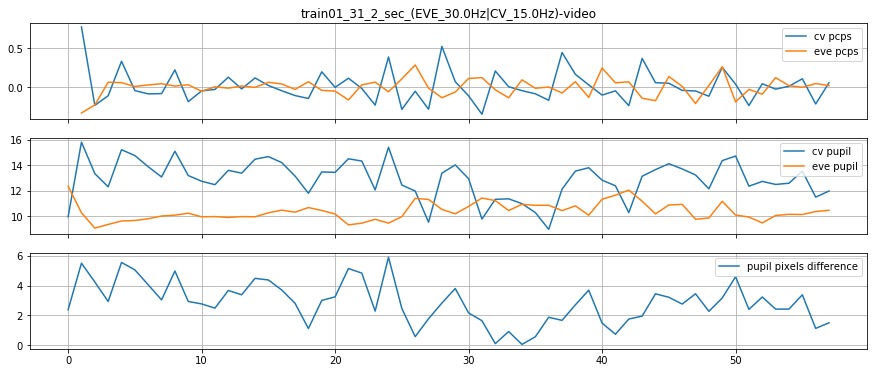

58 58
in terms of pupil radius
diff between two mean| max| min: 2.8652931034482756 5.911 0.047

diff sd 1.3890182840411833
eve mean| max| min: 10.390517241379309 12.36 9.097
cv mean| max| min: 12.911258620689656 15.8 9.0

cv sd 1.4897199639685217

eve sd 0.6769476942402696
**medcouple 0.0
IQR 3.5 lower 11.75 Q1 17.0 Q3 20.5 upper 25.75
remove ratio  0.04 

**medcouple 0.0
IQR 12.0 lower 0.0 Q1 36.0 Q3 48.0 upper 84.0
remove ratio  0.03 

**medcouple 0.0
IQR 25.5 lower 78.5 Q1 155.0 Q3 180.5 upper 257.0
remove ratio  0.0 

** after clean cv data, remove ratio 0.06629834254143652 

**medcouple 0.0
IQR 0.5684003829956055 lower 9.72 Q1 10.574658393859863 Q3 11.143058776855469 upper 12.0
remove ratio  0.05 

**medcouple -0.1
IQR 0.5416984558105469 lower 9.06 Q1 10.273479461669922 Q3 10.815177917480469 upper 11.39
remove ratio  0.05 



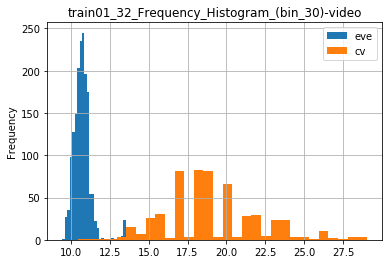

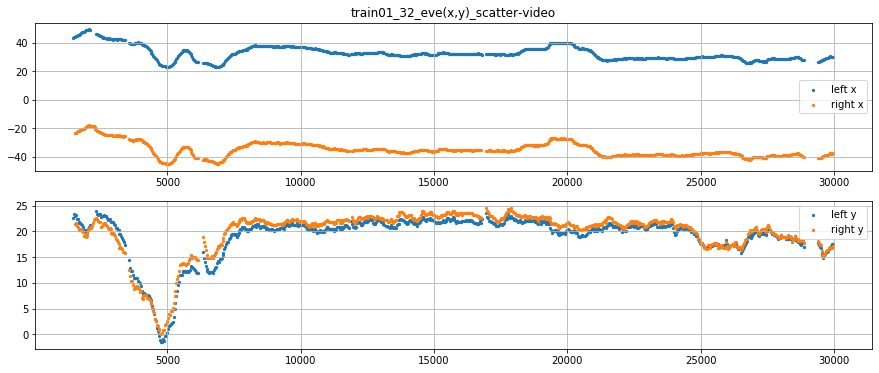

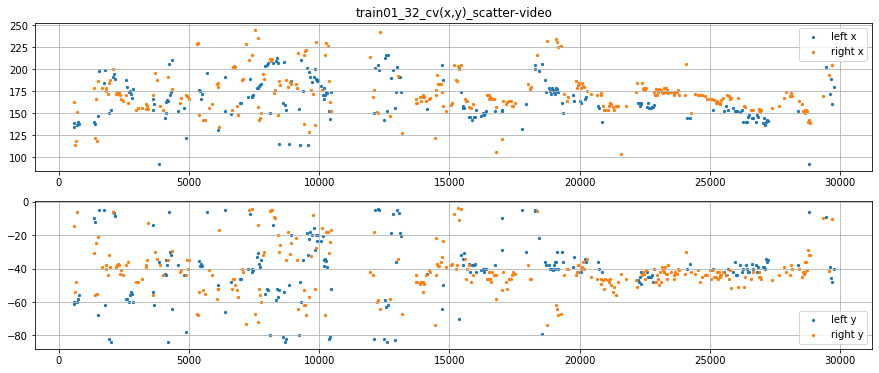

cv db
ts len 494
215
292
470

eve db
ts len 900
815
819
823
EVE 30.0 hz | CV 16.0 hz


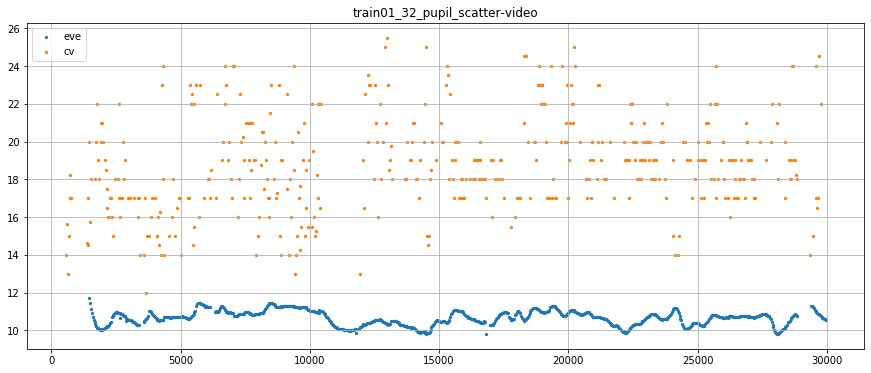

1 SEC Timeframe
video length 30.0
video length 30.0


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


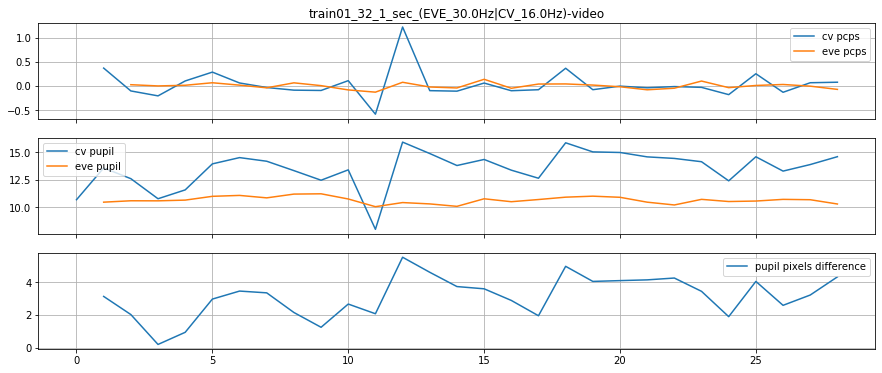

29 29
in terms of pupil radius
diff between two mean| max| min: 3.112821428571429 5.507 0.191

diff sd 1.2255972029286502
eve mean| max| min: 10.662464285714288 11.236 10.062
cv mean| max| min: 13.526896551724137 15.943999999999999 8.0

cv sd 1.6506088812779445

eve sd 0.303317664944439
2 SEC Timeframe
video length 30.0
video length 30.0


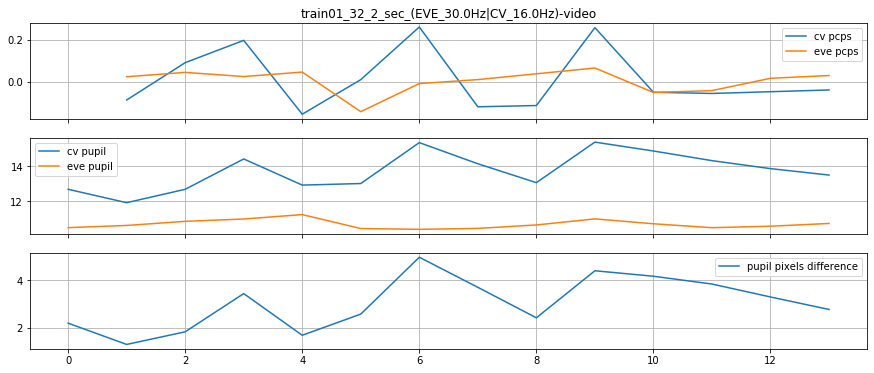

14 14
in terms of pupil radius
diff between two mean| max| min: 3.0424285714285717 4.964 1.304

diff sd 1.0617153717509438
eve mean| max| min: 10.669285714285712 11.221 10.378
cv mean| max| min: 13.711714285714285 15.370999999999999 11.902999999999999

cv sd 1.0300695141987417

eve sd 0.24153598624855305


In [192]:
cv_1, s30_cv1, s31_cv1, s32_cv1 = input_data('train01')
run('30', s30_cv1, 'train01')
run('31', s31_cv1, 'train01')
run('32', s32_cv1, 'train01')

**medcouple 0.4
IQR 3.75 lower 12.86 Q1 14.25 Q3 18.0 upper 45.86
remove ratio  0.01 

**medcouple 0.2
IQR 12.25 lower 20.5 Q1 38.75 Q3 51.0 upper 132.79
remove ratio  0.01 

**medcouple 0.3
IQR 27.0 lower 118.16 Q1 146.5 Q3 173.5 upper 442.43
remove ratio  0.01 

** after clean cv data, remove ratio 0.02409638554216864 

**medcouple 0.0
IQR 0.953643798828125 lower 8.03 Q1 9.460046768188477 Q3 10.413690567016602 upper 11.84
remove ratio  0.0 

**medcouple -0.0
IQR 0.9404339790344238 lower 7.65 Q1 9.057705402374268 Q3 9.998139381408691 upper 11.41
remove ratio  0.0 



C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


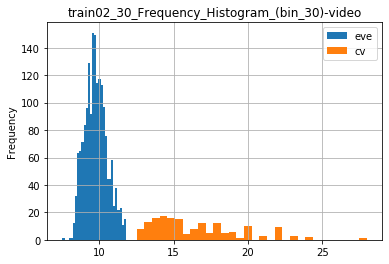

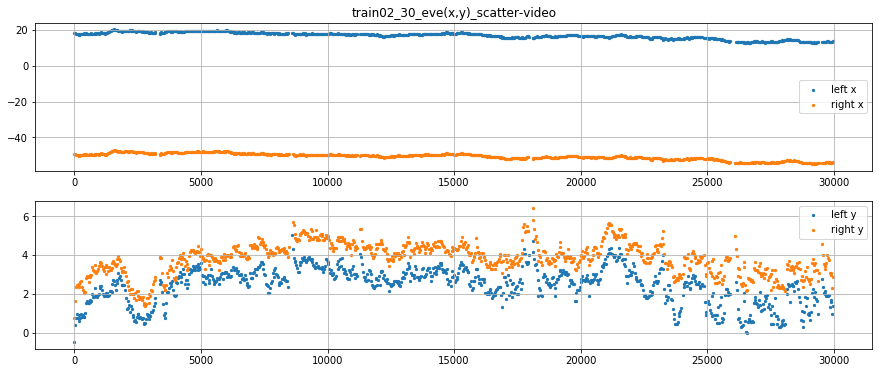

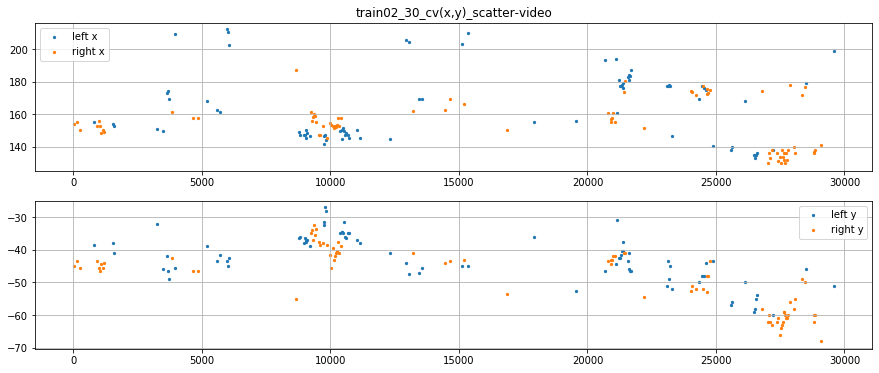

cv db
ts len 165
81
81
162

eve db
ts len 900
871
872
874
EVE 30.0 hz | CV 6.0 hz


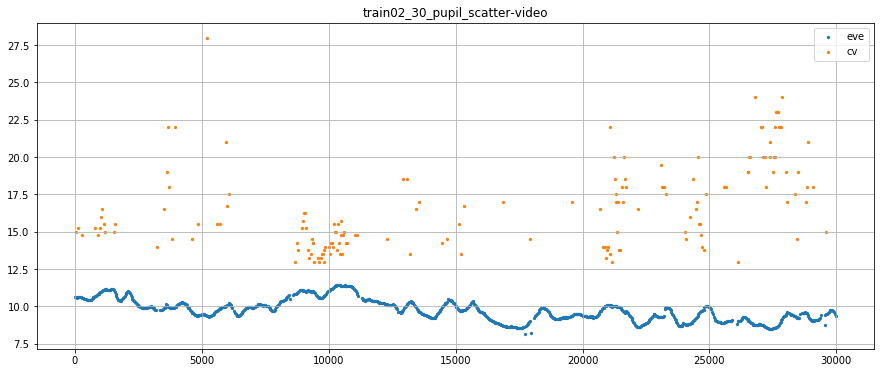

1 SEC Timeframe
video length 30.0
video length 30.0


C:\Users\kaixi\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


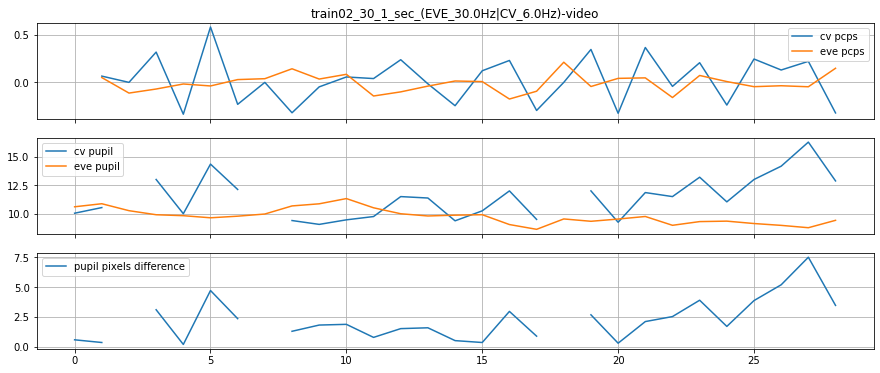

29 29
in terms of pupil radius
diff between two mean| max| min: 2.2246923076923077 7.508 0.175

diff sd 1.7396504239740627
eve mean| max| min: 9.779827586206897 11.326 8.629
cv mean| max| min: 11.418730769230772 16.278 9.062

cv sd 1.8233256715238422

eve sd 0.6598930983939497
2 SEC Timeframe
video length 30.0
video length 30.0


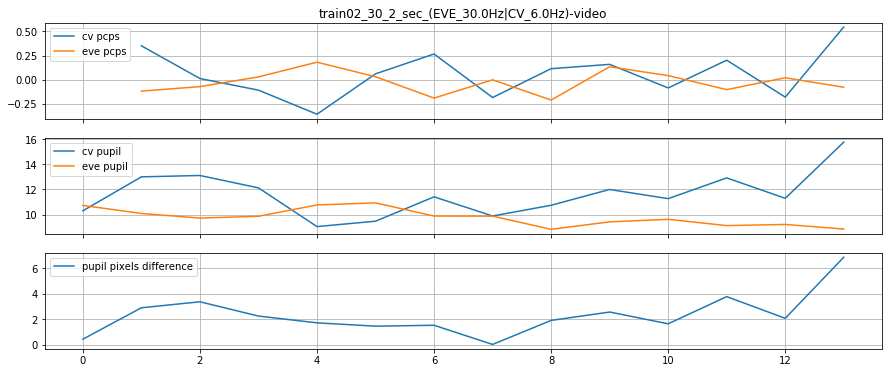

14 14
in terms of pupil radius
diff between two mean| max| min: 2.3192142857142857 6.881 0.011

diff sd 1.5994705900288844
eve mean| max| min: 9.793428571428572 10.939 8.845
cv mean| max| min: 11.600071428571429 15.75 9.062

cv sd 1.6908897262466678

eve sd 0.6512276005784013
**medcouple 0.0
IQR 1.0 lower 14.5 Q1 16.0 Q3 17.0 upper 18.5
remove ratio  0.16 

**medcouple -0.2
IQR 8.5 lower -12.75 Q1 44.0 Q3 52.5 upper 65.16
remove ratio  0.0 

**medcouple 0.0
IQR 10.0 lower 122.0 Q1 152.0 Q3 162.0 upper 192.0
remove ratio  0.03 

** after clean cv data, remove ratio 0.18591549295774645 

**medcouple 0.2
IQR 0.42566680908203125 lower 7.49 Q1 7.811122417449951 Q3 8.236789226531982 upper 9.66
remove ratio  0.15 

**medcouple 0.2
IQR 0.3738856315612793 lower 7.47 Q1 7.751303672790527 Q3 8.125189304351807 upper 9.37
remove ratio  0.15 



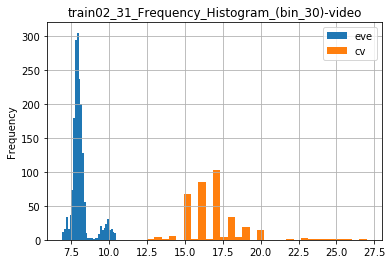

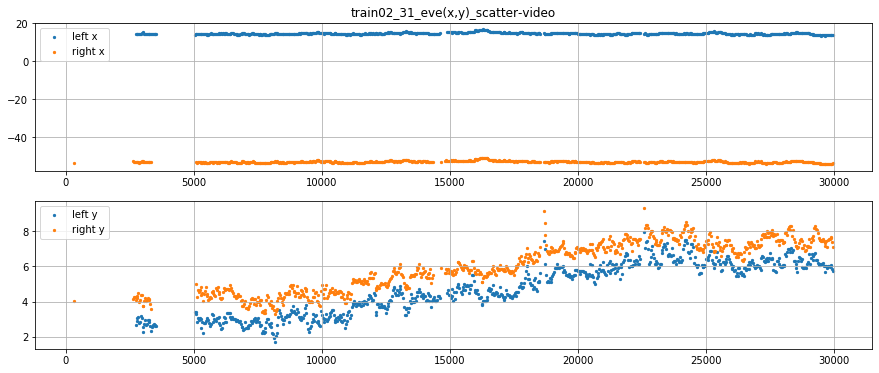

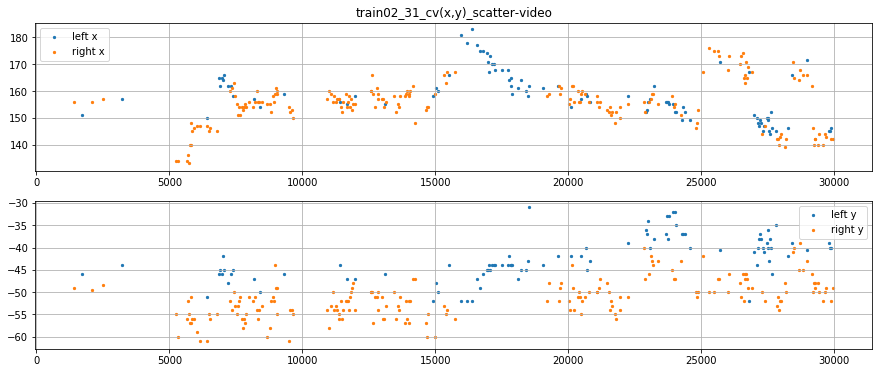

cv db
ts len 353
94
195
289

eve db
ts len 900
757
750
766
EVE 30.0 hz | CV 12.0 hz


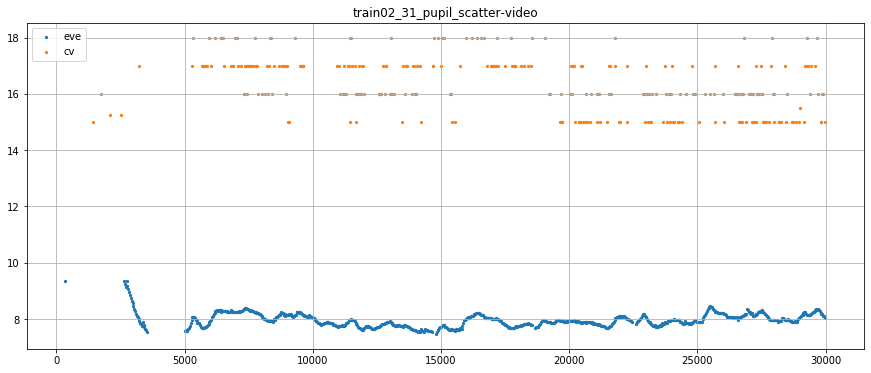

1 SEC Timeframe
video length 30.0
video length 30.0


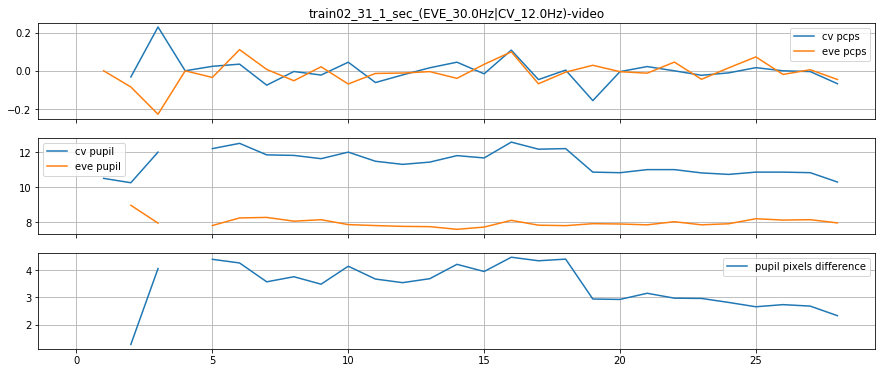

29 29
in terms of pupil radius
diff between two mean| max| min: 3.439346153846154 4.469 1.286

diff sd 0.7666058029395497
eve mean| max| min: 8.03074074074074 9.36 7.59
cv mean| max| min: 11.384925925925925 12.571000000000002 10.25

cv sd 0.6625421817976421

eve sd 0.3654107371968023
2 SEC Timeframe
video length 30.0
video length 30.0


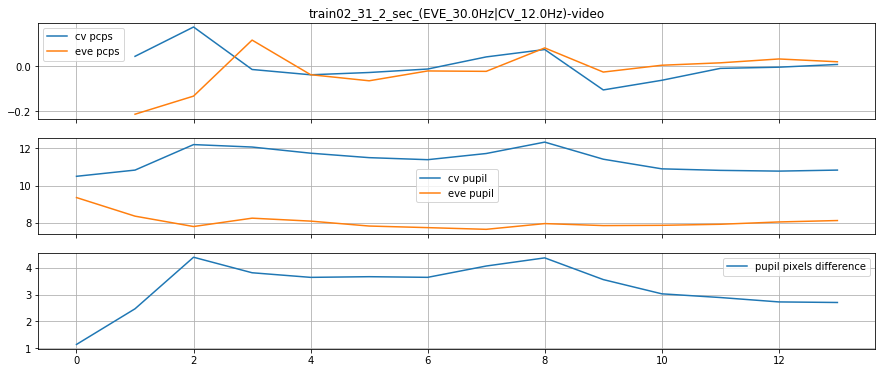

14 14
in terms of pupil radius
diff between two mean| max| min: 3.293642857142857 4.393 1.14

diff sd 0.8410339391098874
eve mean| max| min: 8.065857142857144 9.36 7.657
cv mean| max| min: 11.3595 12.332999999999998 10.5

cv sd 0.5727532191092422

eve sd 0.4056291158088095
**medcouple 0.0
IQR 4.5 lower 6.75 Q1 13.5 Q3 18.0 upper 24.75
remove ratio  0.0 

**medcouple 0.2
IQR 10.25 lower 24.48 Q1 39.75 Q3 50.0 upper 118.44
remove ratio  0.0 

**medcouple -0.0
IQR 36.25 lower 27.25 Q1 136.0 Q3 172.25 upper 281.0
remove ratio  0.0 

** after clean cv data, remove ratio 0.0 

**medcouple 0.1
IQR 0.6553359031677246 lower 7.64 Q1 8.329946041107178 Q3 8.985281944274902 upper 10.45
remove ratio  0.09 

**medcouple -0.1
IQR 0.632272481918335 lower 6.57 Q1 7.982414960861206 Q3 8.614687442779541 upper 9.28
remove ratio  0.13 



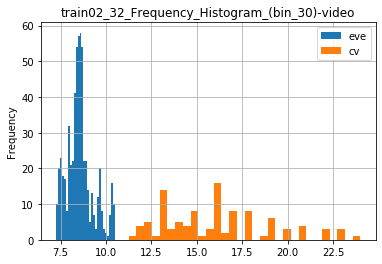

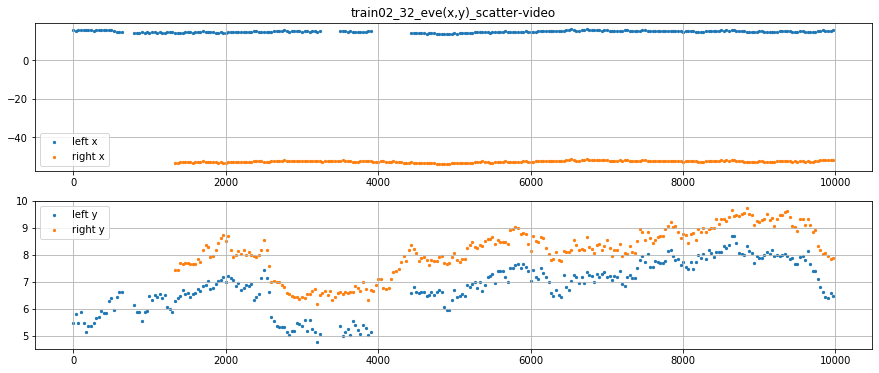

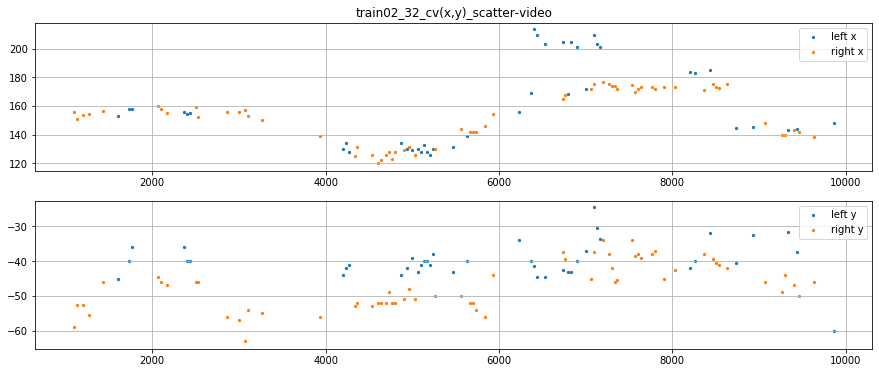

cv db
ts len 102
41
63
102

eve db
ts len 300
274
260
296
EVE 30.0 hz | CV 10.0 hz


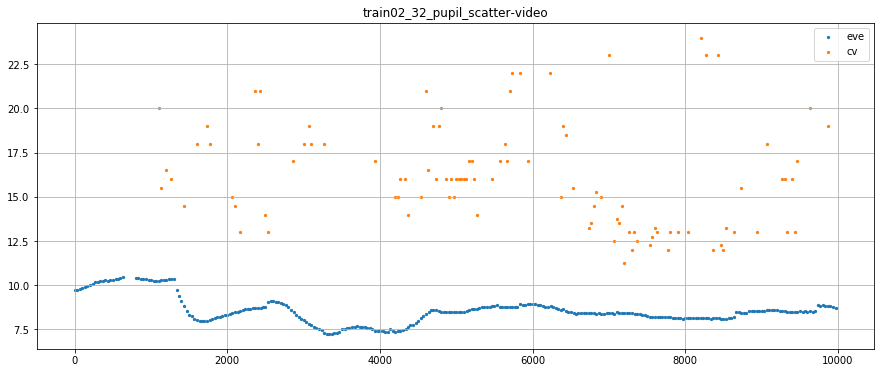

1 SEC Timeframe
video length 10.0
video length 10.0


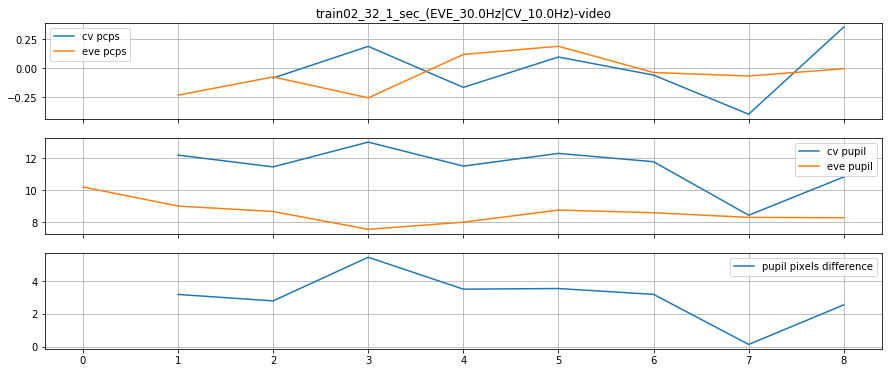

9 9
in terms of pupil radius
diff between two mean| max| min: 3.04575 5.456 0.136

diff sd 1.3735446616328135
eve mean| max| min: 8.586333333333334 10.194 7.544
cv mean| max| min: 11.431125 13.0 8.426

cv sd 1.289741198603425

eve sd 0.7005732573320861
2 SEC Timeframe
video length 10.0
video length 10.0


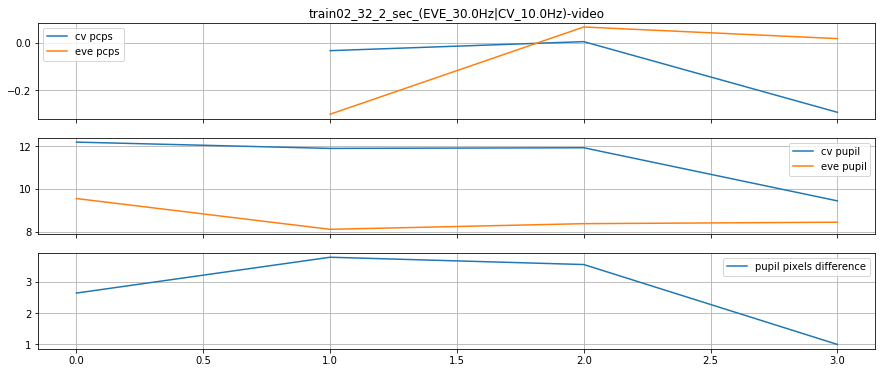

4 4
in terms of pupil radius
diff between two mean| max| min: 2.7477500000000004 3.791 0.999

diff sd 1.0968302911116194
eve mean| max| min: 8.61225 9.544 8.102
cv mean| max| min: 11.36 12.187999999999999 9.435

cv sd 1.1172951713848938

eve sd 0.5522057474347764


In [193]:
cv_2, s30_cv2, s31_cv2, s32_cv2  = input_data('train02')
run('30', s30_cv2, 'train02')
run('31', s31_cv2, 'train02')
run('32', s32_cv2, 'train02')